# Wine Quality Dataset

The Wine Quality Dataset involves predicting the quality of white wines on a scale given chemical measures of each wine.

It is a multi-class classification problem, but could also be framed as a regression problem. The number of observations for each class is not balanced. There are 4,898 observations with 11 input variables and one output variable. The variable names are as follows:

### Input Features for classification
- Fixed acidity.
- Volatile acidity.
- Citric acid.
- Residual sugar.
- Chlorides.
- Free sulfur dioxide.
- Total sulfur dioxide.
- Density.
- pH.
- Sulphates.
- Alcohol.

### Output Feature for classification
- Quality (score between 0 and 10).

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from optuna.visualization.matplotlib import plot_param_importances

In [3]:
df = pd.read_csv("/content/winequality-red.csv")

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [7]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
df = df[~df.duplicated()]

In [9]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [10]:
df['quality'].value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

In [11]:
X=df.drop(["quality"],axis=1)

In [12]:
y=df["quality"]

In [13]:
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [14]:
y

0       5
1       5
2       5
3       6
5       5
       ..
1593    6
1594    5
1595    6
1597    5
1598    6
Name: quality, Length: 1359, dtype: int64

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=25)

In [16]:
X_train.shape,X_test.shape

((1019, 11), (340, 11))

In [17]:
y_train.shape,y_test.shape

((1019,), (340,))

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit_transform(X_train)

array([[ 0.05556106,  1.14595167, -0.80746929, ..., -0.7789901 ,
         0.97984883, -0.76471258],
       [-0.40287393,  1.390986  , -0.30277003, ..., -1.23590452,
        -1.29989078, -1.13510414],
       [-0.17365643,  3.51461692, -0.30277003, ...,  0.20011225,
        -1.11991134,  0.06866844],
       ...,
       [ 0.45669167, -0.3514804 ,  1.1103879 , ..., -1.49699848,
        -0.39999357, -1.22770203],
       [ 2.40504036, -0.40593247,  1.81696687, ..., -2.08445989,
         1.27981456, -0.20912523],
       [-0.63209142,  0.38362262, -1.26169862, ...,  0.98339413,
        -0.75995245,  1.27244102]])

In [20]:
X_train.shape

(1019, 11)

In [21]:
X_test=scaler.transform(X_test)

In [22]:
X_test.shape

(340, 11)

In [23]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [24]:
y_test = le.transform(y_test)

In [25]:
model = RandomForestClassifier(n_estimators=50,max_depth=8,criterion = 'gini' ,oob_score=True,random_state=30)

In [26]:
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, n_estimators=50, oob_score=True,
                       random_state=30)

In [27]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [28]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [29]:
y_pred

array([2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3,
       2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 1, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 3, 3,
       3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3,

In [30]:
accuracy_score(y_test,y_pred)

0.45294117647058824

In [31]:
def objective(trail,data=X,target=y):  
  le = LabelEncoder()
  train_x,test_x,train_y,test_y=train_test_split(data,target,test_size=0.25,random_state=30)
  train_y = le.fit_transform(train_y)
  test_y = le.transform(test_y)
  param={
      "tree_method":"gpu_hist",
      'subsample' :trail.suggest_float('subsample' , 0.1,1,step=0.1),
      'learning_rate' : trail.suggest_float('learning_rate' , 0.001,0.008,step=0.001),
      'n_estimators' :100,
      'max_depth' :trail.suggest_int('max_depth',3,8,step=1),
      'random_state' :trail.suggest_int('random_state',10,50),
      'min_child_weight' :trail.suggest_int('min_child_weight' ,1,20)
      }
  Xgb_classifier_model=xgb.XGBClassifier(**param)
  Xgb_classifier_model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=True)
  y_pred = Xgb_classifier_model.predict(X_test)
  acc = accuracy_score(y_pred, test_y)
  print(f"Model Accuracy: {round(acc, 6)}")
  print(f"Model Parameters: {param}")
  return acc  # return our objective value

In [32]:
find_params=optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler())
find_params.optimize(objective,n_trials=100)
find_params.best_trial.params

[I 2023-05-26 15:20:26,336] A new study created in memory with name: no-name-af87b52e-123d-4747-af45-8e7c7e963948


[0]	validation_0-mlogloss:1.78968
[1]	validation_0-mlogloss:1.78763
[2]	validation_0-mlogloss:1.78565
[3]	validation_0-mlogloss:1.78371
[4]	validation_0-mlogloss:1.78172
[5]	validation_0-mlogloss:1.77975
[6]	validation_0-mlogloss:1.77787
[7]	validation_0-mlogloss:1.77591
[8]	validation_0-mlogloss:1.77392
[9]	validation_0-mlogloss:1.77202
[10]	validation_0-mlogloss:1.77007
[11]	validation_0-mlogloss:1.76818
[12]	validation_0-mlogloss:1.76631
[13]	validation_0-mlogloss:1.76443
[14]	validation_0-mlogloss:1.76262
[15]	validation_0-mlogloss:1.76077
[16]	validation_0-mlogloss:1.75886
[17]	validation_0-mlogloss:1.75700
[18]	validation_0-mlogloss:1.75517
[19]	validation_0-mlogloss:1.75338
[20]	validation_0-mlogloss:1.75152
[21]	validation_0-mlogloss:1.74967
[22]	validation_0-mlogloss:1.74785
[23]	validation_0-mlogloss:1.74595
[24]	validation_0-mlogloss:1.74414
[25]	validation_0-mlogloss:1.74236
[26]	validation_0-mlogloss:1.74052
[27]	validation_0-mlogloss:1.73870
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:20:28,135] Trial 0 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.9, 'learning_rate': 0.002, 'max_depth': 6, 'random_state': 43, 'min_child_weight': 13}. Best is trial 0 with value: 0.36764705882352944.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.9, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 6, 'random_state': 43, 'min_child_weight': 13}
[0]	validation_0-mlogloss:1.78879
[1]	validation_0-mlogloss:1.78585
[2]	validation_0-mlogloss:1.78292
[3]	validation_0-mlogloss:1.78000
[4]	validation_0-mlogloss:1.77710
[5]	validation_0-mlogloss:1.77422
[6]	validation_0-mlogloss:1.77136
[7]	validation_0-mlogloss:1.76849
[8]	validation_0-mlogloss:1.76566
[9]	validation_0-mlogloss:1.76281
[10]	validation_0-mlogloss:1.76002
[11]	validation_0-mlogloss:1.75720
[12]	validation_0-mlogloss:1.75444
[13]	validation_0-mlogloss:1.75170
[14]	validation_0-mlogloss:1.74895
[15]	validation_0-mlogloss:1.74624
[16]	validation_0-mlogloss:1.74352
[17]	validation_0-mlogloss:1.74080
[18]	validation_0-mlogloss:1.73814
[19]	validation_0-mlogloss:1.73546
[20]	validation_0-mlogloss:1.73282
[21]	validation_0-mlogloss:1.73016
[22]	validation_0-mlogloss:1.72754
[23]	valida

[I 2023-05-26 15:20:28,993] Trial 1 finished with value: 0.3735294117647059 and parameters: {'subsample': 1.0, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 36, 'min_child_weight': 16}. Best is trial 1 with value: 0.3735294117647059.


Model Accuracy: 0.373529
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 1.0, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 36, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78705
[1]	validation_0-mlogloss:1.78245
[2]	validation_0-mlogloss:1.77753
[3]	validation_0-mlogloss:1.77287
[4]	validation_0-mlogloss:1.76838
[5]	validation_0-mlogloss:1.76378
[6]	validation_0-mlogloss:1.75904
[7]	validation_0-mlogloss:1.75439
[8]	validation_0-mlogloss:1.74988
[9]	validation_0-mlogloss:1.74563
[10]	validation_0-mlogloss:1.74128
[11]	validation_0-mlogloss:1.73718
[12]	validation_0-mlogloss:1.73273
[13]	validation_0-mlogloss:1.72862
[14]	validation_0-mlogloss:1.72457
[15]	validation_0-mlogloss:1.72041
[16]	validation_0-mlogloss:1.71631
[17]	validation_0-mlogloss:1.71207
[18]	validation_0-mlogloss:1.70805
[19]	validation_0-mlogloss:1.70405
[20]	validation_0-mlogloss:1.69999
[21]	validation_0-mlogloss:1.69616
[22]	validation_0-mlogloss:1.69211
[23]	valida

[I 2023-05-26 15:20:30,093] Trial 2 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.5, 'learning_rate': 0.005, 'max_depth': 4, 'random_state': 25, 'min_child_weight': 12}. Best is trial 1 with value: 0.3735294117647059.


[0]	validation_0-mlogloss:1.78454
[1]	validation_0-mlogloss:1.77757
[2]	validation_0-mlogloss:1.77043
[3]	validation_0-mlogloss:1.76373
[4]	validation_0-mlogloss:1.75732
[5]	validation_0-mlogloss:1.75059
[6]	validation_0-mlogloss:1.74401
[7]	validation_0-mlogloss:1.73727
[8]	validation_0-mlogloss:1.73090
[9]	validation_0-mlogloss:1.72448
[10]	validation_0-mlogloss:1.71783
[11]	validation_0-mlogloss:1.71151
[12]	validation_0-mlogloss:1.70501
[13]	validation_0-mlogloss:1.69889
[14]	validation_0-mlogloss:1.69264
[15]	validation_0-mlogloss:1.68665
[16]	validation_0-mlogloss:1.68066
[17]	validation_0-mlogloss:1.67494
[18]	validation_0-mlogloss:1.66927
[19]	validation_0-mlogloss:1.66352
[20]	validation_0-mlogloss:1.65777
[21]	validation_0-mlogloss:1.65206
[22]	validation_0-mlogloss:1.64646
[23]	validation_0-mlogloss:1.64097
[24]	validation_0-mlogloss:1.63546
[25]	validation_0-mlogloss:1.63028
[26]	validation_0-mlogloss:1.62547
[27]	validation_0-mlogloss:1.61997
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:20:32,053] Trial 3 finished with value: 0.34705882352941175 and parameters: {'subsample': 0.8, 'learning_rate': 0.007, 'max_depth': 7, 'random_state': 19, 'min_child_weight': 2}. Best is trial 1 with value: 0.3735294117647059.


Model Accuracy: 0.347059
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.8, 'learning_rate': 0.007, 'n_estimators': 100, 'max_depth': 7, 'random_state': 19, 'min_child_weight': 2}
[0]	validation_0-mlogloss:1.78472
[1]	validation_0-mlogloss:1.77778
[2]	validation_0-mlogloss:1.77093
[3]	validation_0-mlogloss:1.76411
[4]	validation_0-mlogloss:1.75741
[5]	validation_0-mlogloss:1.75083
[6]	validation_0-mlogloss:1.74437
[7]	validation_0-mlogloss:1.73792
[8]	validation_0-mlogloss:1.73154
[9]	validation_0-mlogloss:1.72534
[10]	validation_0-mlogloss:1.71908
[11]	validation_0-mlogloss:1.71299
[12]	validation_0-mlogloss:1.70687
[13]	validation_0-mlogloss:1.70086
[14]	validation_0-mlogloss:1.69499
[15]	validation_0-mlogloss:1.68913
[16]	validation_0-mlogloss:1.68344
[17]	validation_0-mlogloss:1.67771
[18]	validation_0-mlogloss:1.67209
[19]	validation_0-mlogloss:1.66647
[20]	validation_0-mlogloss:1.66094
[21]	validation_0-mlogloss:1.65551
[22]	validation_0-mlogloss:1.65010
[23]	validat

[I 2023-05-26 15:20:33,196] Trial 4 finished with value: 0.37058823529411766 and parameters: {'subsample': 1.0, 'learning_rate': 0.007, 'max_depth': 4, 'random_state': 33, 'min_child_weight': 16}. Best is trial 1 with value: 0.3735294117647059.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 1.0, 'learning_rate': 0.007, 'n_estimators': 100, 'max_depth': 4, 'random_state': 33, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78377
[1]	validation_0-mlogloss:1.77591
[2]	validation_0-mlogloss:1.76798
[3]	validation_0-mlogloss:1.76046
[4]	validation_0-mlogloss:1.75295
[5]	validation_0-mlogloss:1.74536
[6]	validation_0-mlogloss:1.73801
[7]	validation_0-mlogloss:1.73077
[8]	validation_0-mlogloss:1.72364
[9]	validation_0-mlogloss:1.71644
[10]	validation_0-mlogloss:1.70902
[11]	validation_0-mlogloss:1.70231
[12]	validation_0-mlogloss:1.69543
[13]	validation_0-mlogloss:1.68896
[14]	validation_0-mlogloss:1.68212
[15]	validation_0-mlogloss:1.67565
[16]	validation_0-mlogloss:1.66897
[17]	validation_0-mlogloss:1.66248
[18]	validation_0-mlogloss:1.65629
[19]	validation_0-mlogloss:1.64978
[20]	validation_0-mlogloss:1.64361
[21]	validation_0-mlogloss:1.63769
[22]	validation_0-mlogloss:1.63180
[23]	valida

[I 2023-05-26 15:20:35,020] Trial 5 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.9, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 20, 'min_child_weight': 9}. Best is trial 1 with value: 0.3735294117647059.


[0]	validation_0-mlogloss:1.78980
[1]	validation_0-mlogloss:1.78778
[2]	validation_0-mlogloss:1.78575
[3]	validation_0-mlogloss:1.78374
[4]	validation_0-mlogloss:1.78171
[5]	validation_0-mlogloss:1.77969
[6]	validation_0-mlogloss:1.77775
[7]	validation_0-mlogloss:1.77579
[8]	validation_0-mlogloss:1.77382
[9]	validation_0-mlogloss:1.77193
[10]	validation_0-mlogloss:1.76995
[11]	validation_0-mlogloss:1.76806
[12]	validation_0-mlogloss:1.76604
[13]	validation_0-mlogloss:1.76410
[14]	validation_0-mlogloss:1.76217
[15]	validation_0-mlogloss:1.76027
[16]	validation_0-mlogloss:1.75843
[17]	validation_0-mlogloss:1.75655
[18]	validation_0-mlogloss:1.75463
[19]	validation_0-mlogloss:1.75280
[20]	validation_0-mlogloss:1.75093
[21]	validation_0-mlogloss:1.74913
[22]	validation_0-mlogloss:1.74732
[23]	validation_0-mlogloss:1.74547
[24]	validation_0-mlogloss:1.74361
[25]	validation_0-mlogloss:1.74172
[26]	validation_0-mlogloss:1.73996
[27]	validation_0-mlogloss:1.73822
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:20:37,304] Trial 6 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.8, 'learning_rate': 0.002, 'max_depth': 6, 'random_state': 15, 'min_child_weight': 10}. Best is trial 1 with value: 0.3735294117647059.


[0]	validation_0-mlogloss:1.78827
[1]	validation_0-mlogloss:1.78314
[2]	validation_0-mlogloss:1.77899
[3]	validation_0-mlogloss:1.77447
[4]	validation_0-mlogloss:1.77100
[5]	validation_0-mlogloss:1.76710
[6]	validation_0-mlogloss:1.76272
[7]	validation_0-mlogloss:1.75815
[8]	validation_0-mlogloss:1.75444
[9]	validation_0-mlogloss:1.75012
[10]	validation_0-mlogloss:1.74630
[11]	validation_0-mlogloss:1.74176
[12]	validation_0-mlogloss:1.73763
[13]	validation_0-mlogloss:1.73401
[14]	validation_0-mlogloss:1.73012
[15]	validation_0-mlogloss:1.72708
[16]	validation_0-mlogloss:1.72374
[17]	validation_0-mlogloss:1.72023
[18]	validation_0-mlogloss:1.71667
[19]	validation_0-mlogloss:1.71302
[20]	validation_0-mlogloss:1.70964
[21]	validation_0-mlogloss:1.70613
[22]	validation_0-mlogloss:1.70338
[23]	validation_0-mlogloss:1.69952
[24]	validation_0-mlogloss:1.69524
[25]	validation_0-mlogloss:1.69139
[26]	validation_0-mlogloss:1.68757
[27]	validation_0-mlogloss:1.68409
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:20:38,914] Trial 7 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.1, 'learning_rate': 0.005, 'max_depth': 4, 'random_state': 30, 'min_child_weight': 3}. Best is trial 1 with value: 0.3735294117647059.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 4, 'random_state': 30, 'min_child_weight': 3}
[0]	validation_0-mlogloss:1.78662
[1]	validation_0-mlogloss:1.78195
[2]	validation_0-mlogloss:1.77754
[3]	validation_0-mlogloss:1.77302
[4]	validation_0-mlogloss:1.76859
[5]	validation_0-mlogloss:1.76418
[6]	validation_0-mlogloss:1.75935
[7]	validation_0-mlogloss:1.75488
[8]	validation_0-mlogloss:1.75051
[9]	validation_0-mlogloss:1.74616
[10]	validation_0-mlogloss:1.74215
[11]	validation_0-mlogloss:1.73801
[12]	validation_0-mlogloss:1.73353
[13]	validation_0-mlogloss:1.72948
[14]	validation_0-mlogloss:1.72520
[15]	validation_0-mlogloss:1.72103
[16]	validation_0-mlogloss:1.71685
[17]	validation_0-mlogloss:1.71269
[18]	validation_0-mlogloss:1.70889
[19]	validation_0-mlogloss:1.70483
[20]	validation_0-mlogloss:1.70074
[21]	validation_0-mlogloss:1.69655
[22]	validation_0-mlogloss:1.69305
[23]	validat

[I 2023-05-26 15:20:40,860] Trial 8 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.005, 'max_depth': 6, 'random_state': 43, 'min_child_weight': 6}. Best is trial 1 with value: 0.3735294117647059.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 6, 'random_state': 43, 'min_child_weight': 6}
[0]	validation_0-mlogloss:1.78520
[1]	validation_0-mlogloss:1.77882
[2]	validation_0-mlogloss:1.77237
[3]	validation_0-mlogloss:1.76609
[4]	validation_0-mlogloss:1.75963
[5]	validation_0-mlogloss:1.75337
[6]	validation_0-mlogloss:1.74739
[7]	validation_0-mlogloss:1.74171
[8]	validation_0-mlogloss:1.73569
[9]	validation_0-mlogloss:1.72975
[10]	validation_0-mlogloss:1.72395
[11]	validation_0-mlogloss:1.71803
[12]	validation_0-mlogloss:1.71212
[13]	validation_0-mlogloss:1.70624
[14]	validation_0-mlogloss:1.70087
[15]	validation_0-mlogloss:1.69558
[16]	validation_0-mlogloss:1.69012
[17]	validation_0-mlogloss:1.68494
[18]	validation_0-mlogloss:1.67952
[19]	validation_0-mlogloss:1.67407
[20]	validation_0-mlogloss:1.66896
[21]	validation_0-mlogloss:1.66410
[22]	validation_0-mlogloss:1.65

[I 2023-05-26 15:20:42,627] Trial 9 finished with value: 0.38235294117647056 and parameters: {'subsample': 0.4, 'learning_rate': 0.007, 'max_depth': 6, 'random_state': 16, 'min_child_weight': 15}. Best is trial 9 with value: 0.38235294117647056.


[0]	validation_0-mlogloss:1.78419
[1]	validation_0-mlogloss:1.77650
[2]	validation_0-mlogloss:1.76943
[3]	validation_0-mlogloss:1.76235
[4]	validation_0-mlogloss:1.75532
[5]	validation_0-mlogloss:1.74846
[6]	validation_0-mlogloss:1.74148
[7]	validation_0-mlogloss:1.73458
[8]	validation_0-mlogloss:1.72780
[9]	validation_0-mlogloss:1.72172
[10]	validation_0-mlogloss:1.71516
[11]	validation_0-mlogloss:1.70866
[12]	validation_0-mlogloss:1.70256
[13]	validation_0-mlogloss:1.69612
[14]	validation_0-mlogloss:1.68984
[15]	validation_0-mlogloss:1.68371
[16]	validation_0-mlogloss:1.67779
[17]	validation_0-mlogloss:1.67166
[18]	validation_0-mlogloss:1.66585
[19]	validation_0-mlogloss:1.66007
[20]	validation_0-mlogloss:1.65455
[21]	validation_0-mlogloss:1.64871
[22]	validation_0-mlogloss:1.64283
[23]	validation_0-mlogloss:1.63733
[24]	validation_0-mlogloss:1.63170
[25]	validation_0-mlogloss:1.62661
[26]	validation_0-mlogloss:1.62124
[27]	validation_0-mlogloss:1.61594
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:20:44,923] Trial 10 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 8, 'random_state': 11, 'min_child_weight': 20}. Best is trial 9 with value: 0.38235294117647056.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.5, 'learning_rate': 0.008, 'n_estimators': 100, 'max_depth': 8, 'random_state': 11, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78908
[1]	validation_0-mlogloss:1.78636
[2]	validation_0-mlogloss:1.78361
[3]	validation_0-mlogloss:1.78099
[4]	validation_0-mlogloss:1.77829
[5]	validation_0-mlogloss:1.77546
[6]	validation_0-mlogloss:1.77281
[7]	validation_0-mlogloss:1.77013
[8]	validation_0-mlogloss:1.76731
[9]	validation_0-mlogloss:1.76485
[10]	validation_0-mlogloss:1.76223
[11]	validation_0-mlogloss:1.75956
[12]	validation_0-mlogloss:1.75712
[13]	validation_0-mlogloss:1.75453
[14]	validation_0-mlogloss:1.75219
[15]	validation_0-mlogloss:1.74969
[16]	validation_0-mlogloss:1.74722
[17]	validation_0-mlogloss:1.74473
[18]	validation_0-mlogloss:1.74225
[19]	validation_0-mlogloss:1.73989
[20]	validation_0-mlogloss:1.73741
[21]	validation_0-mlogloss:1.73484
[22]	validation_0-mlogloss:1.73219
[23]	valida

[I 2023-05-26 15:20:47,500] Trial 11 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 36, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78922
[1]	validation_0-mlogloss:1.78660
[2]	validation_0-mlogloss:1.78383
[3]	validation_0-mlogloss:1.78120
[4]	validation_0-mlogloss:1.77853
[5]	validation_0-mlogloss:1.77585
[6]	validation_0-mlogloss:1.77309
[7]	validation_0-mlogloss:1.77057
[8]	validation_0-mlogloss:1.76808
[9]	validation_0-mlogloss:1.76540
[10]	validation_0-mlogloss:1.76284
[11]	validation_0-mlogloss:1.76024
[12]	validation_0-mlogloss:1.75806
[13]	validation_0-mlogloss:1.75542
[14]	validation_0-mlogloss:1.75294
[15]	validation_0-mlogloss:1.75050
[16]	validation_0-mlogloss:1.74799
[17]	validation_0-mlogloss:1.74546
[18]	validation_0-mlogloss:1.74292
[19]	validation_0-mlogloss:1.74037
[20]	validation_0-mlogloss:1.73803
[21]	validation_0-mlogloss:1.73542
[22]	validation_0-mlogloss:1.73284
[23]	validation_0-mlogloss:1.73055
[24]	validation_0-mlogloss:1.72796
[25]	validation_0-mlogloss:1.72563
[26]	validation_0-mlogloss:1.72336
[27]	validation_0-mlogloss:1.72102
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:20:49,435] Trial 12 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78942
[1]	validation_0-mlogloss:1.78712
[2]	validation_0-mlogloss:1.78448
[3]	validation_0-mlogloss:1.78207
[4]	validation_0-mlogloss:1.77954
[5]	validation_0-mlogloss:1.77706
[6]	validation_0-mlogloss:1.77448
[7]	validation_0-mlogloss:1.77179
[8]	validation_0-mlogloss:1.76956
[9]	validation_0-mlogloss:1.76705
[10]	validation_0-mlogloss:1.76452
[11]	validation_0-mlogloss:1.76191
[12]	validation_0-mlogloss:1.75981
[13]	validation_0-mlogloss:1.75714
[14]	validation_0-mlogloss:1.75492
[15]	validation_0-mlogloss:1.75246
[16]	validation_0-mlogloss:1.74992
[17]	validation_0-mlogloss:1.74767
[18]	validation_0-mlogloss:1.74546
[19]	validation_0-mlogloss:1.74298
[20]	validation_0-mlogloss:1.74072
[21]	validation_0-mlogloss:1.73818
[22]	validation_0-mlogloss:1.73591
[23]	validation_0-mlogloss:1.73367
[24]	validation_0-mlogloss:1.73118
[25]	validation_0-mlogloss:1.72880
[26]	validation_0-mlogloss:1.72675
[27]	validation_0-mlogloss:1.72457
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:20:50,966] Trial 13 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.79081
[1]	validation_0-mlogloss:1.78989
[2]	validation_0-mlogloss:1.78903
[3]	validation_0-mlogloss:1.78811
[4]	validation_0-mlogloss:1.78716
[5]	validation_0-mlogloss:1.78625
[6]	validation_0-mlogloss:1.78534
[7]	validation_0-mlogloss:1.78439
[8]	validation_0-mlogloss:1.78347
[9]	validation_0-mlogloss:1.78260
[10]	validation_0-mlogloss:1.78173
[11]	validation_0-mlogloss:1.78086
[12]	validation_0-mlogloss:1.77991
[13]	validation_0-mlogloss:1.77906
[14]	validation_0-mlogloss:1.77822
[15]	validation_0-mlogloss:1.77733
[16]	validation_0-mlogloss:1.77646
[17]	validation_0-mlogloss:1.77558
[18]	validation_0-mlogloss:1.77471
[19]	validation_0-mlogloss:1.77384
[20]	validation_0-mlogloss:1.77303
[21]	validation_0-mlogloss:1.77223
[22]	validation_0-mlogloss:1.77142
[23]	valida

[I 2023-05-26 15:20:52,652] Trial 14 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 49, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78785
[1]	validation_0-mlogloss:1.78423
[2]	validation_0-mlogloss:1.78063
[3]	validation_0-mlogloss:1.77707
[4]	validation_0-mlogloss:1.77319
[5]	validation_0-mlogloss:1.76933
[6]	validation_0-mlogloss:1.76586
[7]	validation_0-mlogloss:1.76207
[8]	validation_0-mlogloss:1.75841
[9]	validation_0-mlogloss:1.75489
[10]	validation_0-mlogloss:1.75118
[11]	validation_0-mlogloss:1.74751
[12]	validation_0-mlogloss:1.74421
[13]	validation_0-mlogloss:1.74076
[14]	validation_0-mlogloss:1.73735
[15]	validation_0-mlogloss:1.73391
[16]	validation_0-mlogloss:1.73051
[17]	validation_0-mlogloss:1.72722
[18]	validation_0-mlogloss:1.72385
[19]	validation_0-mlogloss:1.72039
[20]	validation_0-mlogloss:1.71702
[21]	validation_0-mlogloss:1.71359
[22]	validation_0-mlogloss:1.71016
[23]	validation_0-mlogloss:1.70687
[24]	validation_0-mlogloss:1.70347
[25]	validation_0-mlogloss:1.70036
[26]	validation_0-mlogloss:1.69710
[27]	validation_0-mlogloss:1.69384
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:20:53,786] Trial 15 finished with value: 0.37941176470588234 and parameters: {'subsample': 0.6, 'learning_rate': 0.004, 'max_depth': 5, 'random_state': 42, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.6, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 5, 'random_state': 42, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78861
[1]	validation_0-mlogloss:1.78596
[2]	validation_0-mlogloss:1.78335
[3]	validation_0-mlogloss:1.78079
[4]	validation_0-mlogloss:1.77784
[5]	validation_0-mlogloss:1.77462
[6]	validation_0-mlogloss:1.77236
[7]	validation_0-mlogloss:1.76974
[8]	validation_0-mlogloss:1.76748
[9]	validation_0-mlogloss:1.76517
[10]	validation_0-mlogloss:1.76276
[11]	validation_0-mlogloss:1.76054
[12]	validation_0-mlogloss:1.75735
[13]	validation_0-mlogloss:1.75480
[14]	validation_0-mlogloss:1.75240
[15]	validation_0-mlogloss:1.74958
[16]	validation_0-mlogloss:1.74679
[17]	validation_0-mlogloss:1.74413
[18]	validation_0-mlogloss:1.74179
[19]	validation_0-mlogloss:1.73883
[20]	validation_0-mlogloss:1.73619
[21]	validation_0-mlogloss:1.73400
[22]	validation_0-mlogloss:1.73091
[23]	validation_0-mlogloss:1.72839


[I 2023-05-26 15:20:54,487] Trial 16 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 14}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 14}
[0]	validation_0-mlogloss:1.79089
[1]	validation_0-mlogloss:1.79003
[2]	validation_0-mlogloss:1.78915
[3]	validation_0-mlogloss:1.78818
[4]	validation_0-mlogloss:1.78728
[5]	validation_0-mlogloss:1.78643
[6]	validation_0-mlogloss:1.78554
[7]	validation_0-mlogloss:1.78469
[8]	validation_0-mlogloss:1.78378
[9]	validation_0-mlogloss:1.78293
[10]	validation_0-mlogloss:1.78200
[11]	validation_0-mlogloss:1.78114
[12]	validation_0-mlogloss:1.78021
[13]	validation_0-mlogloss:1.77935
[14]	validation_0-mlogloss:1.77850
[15]	validation_0-mlogloss:1.77763
[16]	validation_0-mlogloss:1.77672
[17]	validation_0-mlogloss:1.77581
[18]	validation_0-mlogloss:1.77490
[19]	validation_0-mlogloss:1.77404
[20]	validation_0-mlogloss:1.77316
[21]	validation_0-mlogloss:1.77241
[22]	validation_0-mlogloss:1.77153
[23]	valida

[I 2023-05-26 15:20:55,327] Trial 17 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78874
[1]	validation_0-mlogloss:1.78582
[2]	validation_0-mlogloss:1.78268
[3]	validation_0-mlogloss:1.77957
[4]	validation_0-mlogloss:1.77675
[5]	validation_0-mlogloss:1.77395
[6]	validation_0-mlogloss:1.77098
[7]	validation_0-mlogloss:1.76809
[8]	validation_0-mlogloss:1.76527
[9]	validation_0-mlogloss:1.76244
[10]	validation_0-mlogloss:1.75958
[11]	validation_0-mlogloss:1.75664
[12]	validation_0-mlogloss:1.75393
[13]	validation_0-mlogloss:1.75112
[14]	validation_0-mlogloss:1.74844
[15]	validation_0-mlogloss:1.74580
[16]	validation_0-mlogloss:1.74285
[17]	validation_0-mlogloss:1.74012
[18]	validation_0-mlogloss:1.73749
[19]	validation_0-mlogloss:1.73472
[20]	validation_0-mlogloss:1.73213
[21]	validation_0-mlogloss:1.72947
[22]	validation_0-mlogloss:1.72668
[23]	validation_0-m

[I 2023-05-26 15:20:56,405] Trial 18 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.6, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 47, 'min_child_weight': 7}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.6, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 5, 'random_state': 47, 'min_child_weight': 7}
[0]	validation_0-mlogloss:1.78988
[1]	validation_0-mlogloss:1.78803
[2]	validation_0-mlogloss:1.78614
[3]	validation_0-mlogloss:1.78433
[4]	validation_0-mlogloss:1.78250
[5]	validation_0-mlogloss:1.78075
[6]	validation_0-mlogloss:1.77894
[7]	validation_0-mlogloss:1.77710
[8]	validation_0-mlogloss:1.77538
[9]	validation_0-mlogloss:1.77366
[10]	validation_0-mlogloss:1.77190
[11]	validation_0-mlogloss:1.77008
[12]	validation_0-mlogloss:1.76832
[13]	validation_0-mlogloss:1.76661
[14]	validation_0-mlogloss:1.76486
[15]	validation_0-mlogloss:1.76305
[16]	validation_0-mlogloss:1.76132
[17]	validation_0-mlogloss:1.75964
[18]	validation_0-mlogloss:1.75787
[19]	validation_0-mlogloss:1.75620
[20]	validation_0-mlogloss:1.75456
[21]	validation_0-mlogloss:1.75279
[22]	validation_0-mlogloss:1.75107
[23]	validat

[I 2023-05-26 15:20:57,349] Trial 19 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 8, 'random_state': 37, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 8, 'random_state': 37, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78803
[1]	validation_0-mlogloss:1.78456
[2]	validation_0-mlogloss:1.78078
[3]	validation_0-mlogloss:1.77755
[4]	validation_0-mlogloss:1.77426
[5]	validation_0-mlogloss:1.77079
[6]	validation_0-mlogloss:1.76768
[7]	validation_0-mlogloss:1.76400
[8]	validation_0-mlogloss:1.76079
[9]	validation_0-mlogloss:1.75781
[10]	validation_0-mlogloss:1.75412
[11]	validation_0-mlogloss:1.75083
[12]	validation_0-mlogloss:1.74749
[13]	validation_0-mlogloss:1.74424
[14]	validation_0-mlogloss:1.74093
[15]	validation_0-mlogloss:1.73780
[16]	validation_0-mlogloss:1.73446
[17]	validation_0-mlogloss:1.73145
[18]	validation_0-mlogloss:1.72834
[19]	validation_0-mlogloss:1.72520
[20]	validation_0-mlogloss:1.72191
[21]	validation_0-mlogloss:1.71850
[22]	validation_0-mlogloss:1.71537
[23]	valida

[I 2023-05-26 15:20:58,393] Trial 20 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 32, 'min_child_weight': 12}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 32, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.78942
[1]	validation_0-mlogloss:1.78712
[2]	validation_0-mlogloss:1.78448
[3]	validation_0-mlogloss:1.78207
[4]	validation_0-mlogloss:1.77954
[5]	validation_0-mlogloss:1.77706
[6]	validation_0-mlogloss:1.77448
[7]	validation_0-mlogloss:1.77179
[8]	validation_0-mlogloss:1.76956
[9]	validation_0-mlogloss:1.76705
[10]	validation_0-mlogloss:1.76452
[11]	validation_0-mlogloss:1.76191
[12]	validation_0-mlogloss:1.75981
[13]	validation_0-mlogloss:1.75714
[14]	validation_0-mlogloss:1.75492
[15]	validation_0-mlogloss:1.75246
[16]	validation_0-mlogloss:1.74992
[17]	validation_0-mlogloss:1.74767
[18]	validation_0-mlogloss:1.74546
[19]	validation_0-mlogloss:1.74298
[20]	validation_0-mlogloss:1.74072
[21]	validation_0-mlogloss:1.73818
[22]	validation_0-mlogloss:1.73591
[23]	valida

[I 2023-05-26 15:20:59,368] Trial 21 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78915
[1]	validation_0-mlogloss:1.78649
[2]	validation_0-mlogloss:1.78376
[3]	validation_0-mlogloss:1.78101
[4]	validation_0-mlogloss:1.77850
[5]	validation_0-mlogloss:1.77599
[6]	validation_0-mlogloss:1.77324
[7]	validation_0-mlogloss:1.77083
[8]	validation_0-mlogloss:1.76850
[9]	validation_0-mlogloss:1.76604
[10]	validation_0-mlogloss:1.76354
[11]	validation_0-mlogloss:1.76106
[12]	validation_0-mlogloss:1.75877
[13]	validation_0-mlogloss:1.75644
[14]	validation_0-mlogloss:1.75396
[15]	validation_0-mlogloss:1.75154
[16]	validation_0-mlogloss:1.74922
[17]	validation_0-mlogloss:1.74707
[18]	validation_0-mlogloss:1.74468
[19]	validation_0-mlogloss:1.74225
[20]	validation_0-mlogloss:1.74013
[21]	validation_0-mlogloss:1.73800
[22]	validation_0-mlogloss:1.73566
[23]	valida

[I 2023-05-26 15:21:00,432] Trial 22 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 4, 'random_state': 47, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 4, 'random_state': 47, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78984
[1]	validation_0-mlogloss:1.78806
[2]	validation_0-mlogloss:1.78615
[3]	validation_0-mlogloss:1.78434
[4]	validation_0-mlogloss:1.78250
[5]	validation_0-mlogloss:1.78058
[6]	validation_0-mlogloss:1.77875
[7]	validation_0-mlogloss:1.77698
[8]	validation_0-mlogloss:1.77518
[9]	validation_0-mlogloss:1.77338
[10]	validation_0-mlogloss:1.77161
[11]	validation_0-mlogloss:1.76981
[12]	validation_0-mlogloss:1.76812
[13]	validation_0-mlogloss:1.76638
[14]	validation_0-mlogloss:1.76470
[15]	validation_0-mlogloss:1.76297
[16]	validation_0-mlogloss:1.76117
[17]	validation_0-mlogloss:1.75947
[18]	validation_0-mlogloss:1.75776
[19]	validation_0-mlogloss:1.75598
[20]	validation_0-mlogloss:1.75420
[21]	validation_0-mlogloss:1.75245
[22]	validation_0-mlogloss:1.75061
[23]	validation_0-mlogloss:1.74894


[I 2023-05-26 15:21:01,918] Trial 23 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 45, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78915
[1]	validation_0-mlogloss:1.78697
[2]	validation_0-mlogloss:1.78410
[3]	validation_0-mlogloss:1.78171
[4]	validation_0-mlogloss:1.77934
[5]	validation_0-mlogloss:1.77715
[6]	validation_0-mlogloss:1.77424
[7]	validation_0-mlogloss:1.77174
[8]	validation_0-mlogloss:1.76928
[9]	validation_0-mlogloss:1.76691
[10]	validation_0-mlogloss:1.76478
[11]	validation_0-mlogloss:1.76207
[12]	validation_0-mlogloss:1.75990
[13]	validation_0-mlogloss:1.75763
[14]	validation_0-mlogloss:1.75495
[15]	validation_0-mlogloss:1.75269
[16]	validation_0-mlogloss:1.75038
[17]	validation_0-mlogloss:1.74818
[18]	validation_0-mlogloss:1.74606
[19]	validation_0-mlogloss:1.74374
[20]	validation_0-mlogloss:1.74181
[21]	validation_0-mlogloss:1.73933
[22]	validation_0-mlogloss:1.73693
[23]	validation_0-mlogloss:1.73495
[24]	validation_0-mlogloss:1.73256
[25]	validation_0-mlogloss:1.72947
[26]	validation_0-mlogloss:1.72746
[27]	validation_0-mlogloss:1.72494
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:02,659] Trial 24 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78894
[1]	validation_0-mlogloss:1.78620
[2]	validation_0-mlogloss:1.78351
[3]	validation_0-mlogloss:1.78096
[4]	validation_0-mlogloss:1.77812
[5]	validation_0-mlogloss:1.77536
[6]	validation_0-mlogloss:1.77258
[7]	validation_0-mlogloss:1.77014
[8]	validation_0-mlogloss:1.76730
[9]	validation_0-mlogloss:1.76460
[10]	validation_0-mlogloss:1.76192
[11]	validation_0-mlogloss:1.75928
[12]	validation_0-mlogloss:1.75664
[13]	validation_0-mlogloss:1.75425
[14]	validation_0-mlogloss:1.75188
[15]	validation_0-mlogloss:1.74927
[16]	validation_0-mlogloss:1.74700
[17]	validation_0-mlogloss:1.74449
[18]	validation_0-mlogloss:1.74181
[19]	validation_0-mlogloss:1.73941
[20]	validation_0-mlogloss:1.73706
[21]	validation_0-mlogloss:1.73483
[22]	validation_0-mlogloss:1.73251
[23]	validation_0-mlogloss:1.73014
[24]	validation_0-mlogloss:1.72786
[25]	validation_0-mlogloss:1.72536
[26]	validation_0-mlogloss:1.72283
[27]	validation_0-mlogloss:1.72026
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:03,562] Trial 25 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 38, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78680
[1]	validation_0-mlogloss:1.78160
[2]	validation_0-mlogloss:1.77709
[3]	validation_0-mlogloss:1.77232
[4]	validation_0-mlogloss:1.76709
[5]	validation_0-mlogloss:1.76173
[6]	validation_0-mlogloss:1.75693
[7]	validation_0-mlogloss:1.75180
[8]	validation_0-mlogloss:1.74713
[9]	validation_0-mlogloss:1.74309
[10]	validation_0-mlogloss:1.73812
[11]	validation_0-mlogloss:1.73326
[12]	validation_0-mlogloss:1.72866
[13]	validation_0-mlogloss:1.72395
[14]	validation_0-mlogloss:1.71972
[15]	validation_0-mlogloss:1.71489
[16]	validation_0-mlogloss:1.71092
[17]	validation_0-mlogloss:1.70614
[18]	validation_0-mlogloss:1.70163
[19]	validation_0-mlogloss:1.69717
[20]	validation_0-mlogloss:1.69300
[21]	validation_0-mlogloss:1.68870
[22]	validation_0-mlogloss:1.68445
[23]	validation_0-mlogloss:1.68019
[24]	validation_0-mlogloss:1.67649
[25]	validation_0-mlogloss:1.67217
[26]	validation_0-mlogloss:1.66801
[27]	validation_0-mlogloss:1.66383
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:21:04,419] Trial 26 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.006, 'max_depth': 4, 'random_state': 41, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 4, 'random_state': 41, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79080
[1]	validation_0-mlogloss:1.78990
[2]	validation_0-mlogloss:1.78892
[3]	validation_0-mlogloss:1.78801
[4]	validation_0-mlogloss:1.78709
[5]	validation_0-mlogloss:1.78615
[6]	validation_0-mlogloss:1.78523
[7]	validation_0-mlogloss:1.78433
[8]	validation_0-mlogloss:1.78343
[9]	validation_0-mlogloss:1.78252
[10]	validation_0-mlogloss:1.78159
[11]	validation_0-mlogloss:1.78070
[12]	validation_0-mlogloss:1.77980
[13]	validation_0-mlogloss:1.77889
[14]	validation_0-mlogloss:1.77800
[15]	validation_0-mlogloss:1.77711
[16]	validation_0-mlogloss:1.77620
[17]	validation_0-mlogloss:1.77532
[18]	validation_0-mlogloss:1.77441
[19]	validation_0-mlogloss:1.77349
[20]	validation_0-mlogloss:1.77258
[21]	validation_0-mlogloss:1.77165
[22]	validation_0-mlogloss:1.77068
[23]	valida

[I 2023-05-26 15:21:05,457] Trial 27 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.001, 'max_depth': 7, 'random_state': 45, 'min_child_weight': 15}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78993
[1]	validation_0-mlogloss:1.78808
[2]	validation_0-mlogloss:1.78625
[3]	validation_0-mlogloss:1.78434
[4]	validation_0-mlogloss:1.78244
[5]	validation_0-mlogloss:1.78052
[6]	validation_0-mlogloss:1.77868
[7]	validation_0-mlogloss:1.77686
[8]	validation_0-mlogloss:1.77504
[9]	validation_0-mlogloss:1.77318
[10]	validation_0-mlogloss:1.77134
[11]	validation_0-mlogloss:1.76956
[12]	validation_0-mlogloss:1.76774
[13]	validation_0-mlogloss:1.76589
[14]	validation_0-mlogloss:1.76410
[15]	validation_0-mlogloss:1.76234
[16]	validation_0-mlogloss:1.76054
[17]	validation_0-mlogloss:1.75888
[18]	validation_0-mlogloss:1.75714
[19]	validation_0-mlogloss:1.75539
[20]	validation_0-mlogloss:1.75360
[21]	validation_0-mlogloss:1.75182
[22]	validation_0-mlogloss:1.74999
[23]	validation_0-mlogloss:1.74832
[24]	validation_0-mlogloss:1.74656
[25]	validation_0-mlogloss:1.74477
[26]	validation_0-mlogloss:1.74304
[27]	validation_0-mlogloss:1.74125
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:06,413] Trial 28 finished with value: 0.38529411764705884 and parameters: {'subsample': 0.5, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 35, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.385294
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.5, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 35, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78875
[1]	validation_0-mlogloss:1.78569
[2]	validation_0-mlogloss:1.78284
[3]	validation_0-mlogloss:1.78004
[4]	validation_0-mlogloss:1.77714
[5]	validation_0-mlogloss:1.77442
[6]	validation_0-mlogloss:1.77156
[7]	validation_0-mlogloss:1.76866
[8]	validation_0-mlogloss:1.76589
[9]	validation_0-mlogloss:1.76311
[10]	validation_0-mlogloss:1.76034
[11]	validation_0-mlogloss:1.75749
[12]	validation_0-mlogloss:1.75475
[13]	validation_0-mlogloss:1.75205
[14]	validation_0-mlogloss:1.74928
[15]	validation_0-mlogloss:1.74655
[16]	validation_0-mlogloss:1.74394
[17]	validation_0-mlogloss:1.74137
[18]	validation_0-mlogloss:1.73872
[19]	validation_0-mlogloss:1.73612
[20]	validation_0-mlogloss:1.73335
[21]	validation_0-mlogloss:1.73077
[22]	validation_0-mlogloss:1.72822
[23]	valida

[I 2023-05-26 15:21:07,524] Trial 29 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.7000000000000001, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 46, 'min_child_weight': 13}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.7000000000000001, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 5, 'random_state': 46, 'min_child_weight': 13}
[0]	validation_0-mlogloss:1.78823
[1]	validation_0-mlogloss:1.78501
[2]	validation_0-mlogloss:1.78180
[3]	validation_0-mlogloss:1.77856
[4]	validation_0-mlogloss:1.77511
[5]	validation_0-mlogloss:1.77161
[6]	validation_0-mlogloss:1.76796
[7]	validation_0-mlogloss:1.76465
[8]	validation_0-mlogloss:1.76133
[9]	validation_0-mlogloss:1.75880
[10]	validation_0-mlogloss:1.75567
[11]	validation_0-mlogloss:1.75262
[12]	validation_0-mlogloss:1.74969
[13]	validation_0-mlogloss:1.74642
[14]	validation_0-mlogloss:1.74323
[15]	validation_0-mlogloss:1.73961
[16]	validation_0-mlogloss:1.73648
[17]	validation_0-mlogloss:1.73336
[18]	validation_0-mlogloss:1.73031
[19]	validation_0-mlogloss:1.72707
[20]	validation_0-mlogloss:1.72416
[21]	validation_0-mlogloss:1.72165
[22]	validation_0-mlogloss:1.71

[I 2023-05-26 15:21:08,325] Trial 30 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 4, 'random_state': 40, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 4, 'random_state': 40, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79091
[1]	validation_0-mlogloss:1.79004
[2]	validation_0-mlogloss:1.78913
[3]	validation_0-mlogloss:1.78826
[4]	validation_0-mlogloss:1.78733
[5]	validation_0-mlogloss:1.78642
[6]	validation_0-mlogloss:1.78548
[7]	validation_0-mlogloss:1.78462
[8]	validation_0-mlogloss:1.78377
[9]	validation_0-mlogloss:1.78285
[10]	validation_0-mlogloss:1.78197
[11]	validation_0-mlogloss:1.78107
[12]	validation_0-mlogloss:1.78029
[13]	validation_0-mlogloss:1.77937
[14]	validation_0-mlogloss:1.77850
[15]	validation_0-mlogloss:1.77764
[16]	validation_0-mlogloss:1.77675
[17]	validation_0-mlogloss:1.77585
[18]	validation_0-mlogloss:1.77493
[19]	validation_0-mlogloss:1.77402
[20]	validation_0-mlogloss:1.77318
[21]	validation_0-mlogloss:1.77226
[22]	validation_0-mlogloss:1.77132
[23]	valida

[I 2023-05-26 15:21:09,220] Trial 31 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79088
[1]	validation_0-mlogloss:1.79008
[2]	validation_0-mlogloss:1.78920
[3]	validation_0-mlogloss:1.78831
[4]	validation_0-mlogloss:1.78747
[5]	validation_0-mlogloss:1.78661
[6]	validation_0-mlogloss:1.78570
[7]	validation_0-mlogloss:1.78481
[8]	validation_0-mlogloss:1.78392
[9]	validation_0-mlogloss:1.78301
[10]	validation_0-mlogloss:1.78214
[11]	validation_0-mlogloss:1.78121
[12]	validation_0-mlogloss:1.78033
[13]	validation_0-mlogloss:1.77947
[14]	validation_0-mlogloss:1.77860
[15]	validation_0-mlogloss:1.77770
[16]	validation_0-mlogloss:1.77690
[17]	validation_0-mlogloss:1.77598
[18]	validation_0-mlogloss:1.77512
[19]	validation_0-mlogloss:1.77421
[20]	validation_0-mlogloss:1.77341
[21]	validation_0-mlogloss:1.77257
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:10,150] Trial 32 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79033
[1]	validation_0-mlogloss:1.78919
[2]	validation_0-mlogloss:1.78770
[3]	validation_0-mlogloss:1.78646
[4]	validation_0-mlogloss:1.78509
[5]	validation_0-mlogloss:1.78381
[6]	validation_0-mlogloss:1.78259
[7]	validation_0-mlogloss:1.78142
[8]	validation_0-mlogloss:1.78032
[9]	validation_0-mlogloss:1.77903
[10]	validation_0-mlogloss:1.77771
[11]	validation_0-mlogloss:1.77636
[12]	validation_0-mlogloss:1.77502
[13]	validation_0-mlogloss:1.77394
[14]	validation_0-mlogloss:1.77270
[15]	validation_0-mlogloss:1.77149
[16]	validation_0-mlogloss:1.77031
[17]	validation_0-mlogloss:1.76902
[18]	validation_0-mlogloss:1.76785
[19]	validation_0-mlogloss:1.76652
[20]	validation_0-mlogloss:1.76528
[21]	validation_0-mlogloss:1.76422
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:10,882] Trial 33 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 43, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 43, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78897
[1]	validation_0-mlogloss:1.78630
[2]	validation_0-mlogloss:1.78364
[3]	validation_0-mlogloss:1.78092
[4]	validation_0-mlogloss:1.77828
[5]	validation_0-mlogloss:1.77572
[6]	validation_0-mlogloss:1.77315
[7]	validation_0-mlogloss:1.77049
[8]	validation_0-mlogloss:1.76785
[9]	validation_0-mlogloss:1.76507
[10]	validation_0-mlogloss:1.76243
[11]	validation_0-mlogloss:1.75964
[12]	validation_0-mlogloss:1.75685
[13]	validation_0-mlogloss:1.75402
[14]	validation_0-mlogloss:1.75132
[15]	validation_0-mlogloss:1.74876
[16]	validation_0-mlogloss:1.74630
[17]	validation_0-mlogloss:1.74355
[18]	validation_0-mlogloss:1.74102
[19]	validation_0-mlogloss:1.73839
[20]	validation_0-mlogloss:1.73584
[21]	validation_0-mlogloss:1.73339
[22]	validation_0-mlogloss:1.73081
[23]	valida

[I 2023-05-26 15:21:11,983] Trial 34 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.003, 'max_depth': 6, 'random_state': 48, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 6, 'random_state': 48, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78990
[1]	validation_0-mlogloss:1.78810
[2]	validation_0-mlogloss:1.78627
[3]	validation_0-mlogloss:1.78444
[4]	validation_0-mlogloss:1.78251
[5]	validation_0-mlogloss:1.78058
[6]	validation_0-mlogloss:1.77888
[7]	validation_0-mlogloss:1.77708
[8]	validation_0-mlogloss:1.77520
[9]	validation_0-mlogloss:1.77358
[10]	validation_0-mlogloss:1.77187
[11]	validation_0-mlogloss:1.77021
[12]	validation_0-mlogloss:1.76842
[13]	validation_0-mlogloss:1.76669
[14]	validation_0-mlogloss:1.76498
[15]	validation_0-mlogloss:1.76323
[16]	validation_0-mlogloss:1.76158
[17]	validation_0-mlogloss:1.75982
[18]	validation_0-mlogloss:1.75823
[19]	validation_0-mlogloss:1.75655
[20]	validation_0-mlogloss:1.75477
[21]	validation_0-mlogloss:1.75318
[22]	validation_0-mlogloss:1.75140
[23]	valida

[I 2023-05-26 15:21:13,153] Trial 35 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 25, 'min_child_weight': 14}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78601
[1]	validation_0-mlogloss:1.78007
[2]	validation_0-mlogloss:1.77440
[3]	validation_0-mlogloss:1.76909
[4]	validation_0-mlogloss:1.76356
[5]	validation_0-mlogloss:1.75816
[6]	validation_0-mlogloss:1.75284
[7]	validation_0-mlogloss:1.74760
[8]	validation_0-mlogloss:1.74211
[9]	validation_0-mlogloss:1.73720
[10]	validation_0-mlogloss:1.73233
[11]	validation_0-mlogloss:1.72753
[12]	validation_0-mlogloss:1.72246
[13]	validation_0-mlogloss:1.71731
[14]	validation_0-mlogloss:1.71282
[15]	validation_0-mlogloss:1.70801
[16]	validation_0-mlogloss:1.70307
[17]	validation_0-mlogloss:1.69845
[18]	validation_0-mlogloss:1.69357
[19]	validation_0-mlogloss:1.68926
[20]	validation_0-mlogloss:1.68439
[21]	validation_0-mlogloss:1.67980
[22]	validation_0-mlogloss:1.67542
[23]	validation_0-mlogloss:1.67087
[24]	validation_0-mlogloss:1.66647
[25]	validation_0-mlogloss:1.66206
[26]	validation_0-mlogloss:1.65774
[27]	validation_0-mlogloss:1.65341
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:21:14,630] Trial 36 finished with value: 0.3735294117647059 and parameters: {'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 7, 'random_state': 44, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79086
[1]	validation_0-mlogloss:1.78994
[2]	validation_0-mlogloss:1.78910
[3]	validation_0-mlogloss:1.78816
[4]	validation_0-mlogloss:1.78729
[5]	validation_0-mlogloss:1.78644
[6]	validation_0-mlogloss:1.78558
[7]	validation_0-mlogloss:1.78472
[8]	validation_0-mlogloss:1.78383
[9]	validation_0-mlogloss:1.78294
[10]	validation_0-mlogloss:1.78207
[11]	validation_0-mlogloss:1.78117
[12]	validation_0-mlogloss:1.78036
[13]	validation_0-mlogloss:1.77949
[14]	validation_0-mlogloss:1.77863
[15]	validation_0-mlogloss:1.77781
[16]	validation_0-mlogloss:1.77702
[17]	validation_0-mlogloss:1.77619
[18]	validation_0-mlogloss:1.77526
[19]	validation_0-mlogloss:1.77443
[20]	validation_0-mlogloss:1.77354
[21]	validation_0-mlogloss:1.77272
[22]	validation_0-mlogloss:1.77183
[23]	validation_0-mlogloss:1.77093
[24]	validation_0-mlogloss:1.77010
[25]	validation_0-mlogloss:1.76919
[26]	validation_0-mlogloss:1.76842
[27]	validation_0-mlogloss:1.76745
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:15,777] Trial 37 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 35, 'min_child_weight': 12}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 35, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.78840
[1]	validation_0-mlogloss:1.78492
[2]	validation_0-mlogloss:1.78128
[3]	validation_0-mlogloss:1.77777
[4]	validation_0-mlogloss:1.77412
[5]	validation_0-mlogloss:1.77052
[6]	validation_0-mlogloss:1.76696
[7]	validation_0-mlogloss:1.76350
[8]	validation_0-mlogloss:1.76005
[9]	validation_0-mlogloss:1.75645
[10]	validation_0-mlogloss:1.75299
[11]	validation_0-mlogloss:1.74958
[12]	validation_0-mlogloss:1.74665
[13]	validation_0-mlogloss:1.74325
[14]	validation_0-mlogloss:1.73992
[15]	validation_0-mlogloss:1.73656
[16]	validation_0-mlogloss:1.73320
[17]	validation_0-mlogloss:1.72992
[18]	validation_0-mlogloss:1.72652
[19]	validation_0-mlogloss:1.72322
[20]	validation_0-mlogloss:1.71996
[21]	validation_0-mlogloss:1.71651
[22]	validation_0-mlogloss:1.71310
[23]	valida

[I 2023-05-26 15:21:16,796] Trial 38 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.004, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 15}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 15}
[0]	validation_0-mlogloss:1.78721
[1]	validation_0-mlogloss:1.78216
[2]	validation_0-mlogloss:1.77752
[3]	validation_0-mlogloss:1.77323
[4]	validation_0-mlogloss:1.76859
[5]	validation_0-mlogloss:1.76408
[6]	validation_0-mlogloss:1.75978
[7]	validation_0-mlogloss:1.75568
[8]	validation_0-mlogloss:1.75157
[9]	validation_0-mlogloss:1.74717
[10]	validation_0-mlogloss:1.74315
[11]	validation_0-mlogloss:1.73911
[12]	validation_0-mlogloss:1.73478
[13]	validation_0-mlogloss:1.73069
[14]	validation_0-mlogloss:1.72632
[15]	validation_0-mlogloss:1.72227
[16]	validation_0-mlogloss:1.71797
[17]	validation_0-mlogloss:1.71387
[18]	validation_0-mlogloss:1.71010
[19]	validation_0-mlogloss:1.70640
[20]	validation_0-mlogloss:1.70238
[21]	validation_0-mlogloss:1.69828
[22]	validation_0-mlogloss:1.6

[I 2023-05-26 15:21:17,843] Trial 39 finished with value: 0.38823529411764707 and parameters: {'subsample': 0.4, 'learning_rate': 0.005, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.388235
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 4, 'random_state': 22, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78987
[1]	validation_0-mlogloss:1.78838
[2]	validation_0-mlogloss:1.78653
[3]	validation_0-mlogloss:1.78475
[4]	validation_0-mlogloss:1.78323
[5]	validation_0-mlogloss:1.78168
[6]	validation_0-mlogloss:1.78001
[7]	validation_0-mlogloss:1.77821
[8]	validation_0-mlogloss:1.77652
[9]	validation_0-mlogloss:1.77487
[10]	validation_0-mlogloss:1.77307
[11]	validation_0-mlogloss:1.77124
[12]	validation_0-mlogloss:1.76983
[13]	validation_0-mlogloss:1.76833
[14]	validation_0-mlogloss:1.76674
[15]	validation_0-mlogloss:1.76518
[16]	validation_0-mlogloss:1.76394
[17]	validation_0-mlogloss:1.76231
[18]	validation_0-mlogloss:1.76074
[19]	validation_0-mlogloss:1.75934
[20]	validation_0-mlogloss:1.75783
[21]	validation_0-mlogloss:1.75632
[22]	validation_0-mlogloss:1.75456
[23]	valida

[I 2023-05-26 15:21:18,742] Trial 40 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 8}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78940
[1]	validation_0-mlogloss:1.78684
[2]	validation_0-mlogloss:1.78459
[3]	validation_0-mlogloss:1.78267
[4]	validation_0-mlogloss:1.78045
[5]	validation_0-mlogloss:1.77802
[6]	validation_0-mlogloss:1.77628
[7]	validation_0-mlogloss:1.77425
[8]	validation_0-mlogloss:1.77252
[9]	validation_0-mlogloss:1.77076
[10]	validation_0-mlogloss:1.76868
[11]	validation_0-mlogloss:1.76692
[12]	validation_0-mlogloss:1.76450
[13]	validation_0-mlogloss:1.76255
[14]	validation_0-mlogloss:1.76057
[15]	validation_0-mlogloss:1.75787
[16]	validation_0-mlogloss:1.75566
[17]	validation_0-mlogloss:1.75363
[18]	validation_0-mlogloss:1.75183
[19]	validation_0-mlogloss:1.74944
[20]	validation_0-mlogloss:1.74712
[21]	validation_0-mlogloss:1.74537
[22]	validation_0-mlogloss:1.74300
[23]	validation_0-mlogloss:1.74105
[24]	validation_0-mlogloss:1.73903
[25]	validation_0-mlogloss:1.73688
[26]	validation_0-mlogloss:1.73513
[27]	validation_0-mlogloss:1.73339
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:19,538] Trial 41 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 13}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 13}
[0]	validation_0-mlogloss:1.78771
[1]	validation_0-mlogloss:1.78427
[2]	validation_0-mlogloss:1.78093
[3]	validation_0-mlogloss:1.77765
[4]	validation_0-mlogloss:1.77445
[5]	validation_0-mlogloss:1.77124
[6]	validation_0-mlogloss:1.76832
[7]	validation_0-mlogloss:1.76484
[8]	validation_0-mlogloss:1.76157
[9]	validation_0-mlogloss:1.75852
[10]	validation_0-mlogloss:1.75520
[11]	validation_0-mlogloss:1.75215
[12]	validation_0-mlogloss:1.74901
[13]	validation_0-mlogloss:1.74578
[14]	validation_0-mlogloss:1.74247
[15]	validation_0-mlogloss:1.73946
[16]	validation_0-mlogloss:1.73621
[17]	validation_0-mlogloss:1.73303
[18]	validation_0-mlogloss:1.72972
[19]	validation_0-mlogloss:1.72645
[20]	validation_0-mlogloss:1.72360
[21]	validation_0-mlogloss:1.72088
[22]	validation_0-mlogloss:1.71784
[23]	valida

[I 2023-05-26 15:21:20,495] Trial 42 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 34, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 34, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78767
[1]	validation_0-mlogloss:1.78425
[2]	validation_0-mlogloss:1.77990
[3]	validation_0-mlogloss:1.77661
[4]	validation_0-mlogloss:1.77290
[5]	validation_0-mlogloss:1.76919
[6]	validation_0-mlogloss:1.76577
[7]	validation_0-mlogloss:1.76260
[8]	validation_0-mlogloss:1.75921
[9]	validation_0-mlogloss:1.75518
[10]	validation_0-mlogloss:1.75168
[11]	validation_0-mlogloss:1.74857
[12]	validation_0-mlogloss:1.74535
[13]	validation_0-mlogloss:1.74211
[14]	validation_0-mlogloss:1.73820
[15]	validation_0-mlogloss:1.73543
[16]	validation_0-mlogloss:1.73125
[17]	validation_0-mlogloss:1.72792
[18]	validation_0-mlogloss:1.72440
[19]	validation_0-mlogloss:1.72116
[20]	validation_0-mlogloss:1.71702
[21]	validation_0-mlogloss:1.71379
[22]	validation_0-mlogloss:1.70984
[23]	validation_0-mlogloss:1.70616


[I 2023-05-26 15:21:21,309] Trial 43 finished with value: 0.3764705882352941 and parameters: {'subsample': 0.1, 'learning_rate': 0.006, 'max_depth': 3, 'random_state': 31, 'min_child_weight': 14}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.376471
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.006, 'n_estimators': 100, 'max_depth': 3, 'random_state': 31, 'min_child_weight': 14}
[0]	validation_0-mlogloss:1.78760
[1]	validation_0-mlogloss:1.78307
[2]	validation_0-mlogloss:1.77867
[3]	validation_0-mlogloss:1.77444
[4]	validation_0-mlogloss:1.77000
[5]	validation_0-mlogloss:1.76534
[6]	validation_0-mlogloss:1.76050
[7]	validation_0-mlogloss:1.75604
[8]	validation_0-mlogloss:1.75183
[9]	validation_0-mlogloss:1.74825
[10]	validation_0-mlogloss:1.74402
[11]	validation_0-mlogloss:1.74005
[12]	validation_0-mlogloss:1.73574
[13]	validation_0-mlogloss:1.73130
[14]	validation_0-mlogloss:1.72758
[15]	validation_0-mlogloss:1.72349
[16]	validation_0-mlogloss:1.71949
[17]	validation_0-mlogloss:1.71523
[18]	validation_0-mlogloss:1.71126
[19]	validation_0-mlogloss:1.70718
[20]	validation_0-mlogloss:1.70346
[21]	validation_0-mlogloss:1.69966
[22]	validation_0-mlogloss:1.69608
[23]	valida

[I 2023-05-26 15:21:22,298] Trial 44 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.005, 'max_depth': 4, 'random_state': 41, 'min_child_weight': 11}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 4, 'random_state': 41, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.78863
[1]	validation_0-mlogloss:1.78576
[2]	validation_0-mlogloss:1.78282
[3]	validation_0-mlogloss:1.77999
[4]	validation_0-mlogloss:1.77713
[5]	validation_0-mlogloss:1.77437
[6]	validation_0-mlogloss:1.77149
[7]	validation_0-mlogloss:1.76874
[8]	validation_0-mlogloss:1.76588
[9]	validation_0-mlogloss:1.76314
[10]	validation_0-mlogloss:1.76052
[11]	validation_0-mlogloss:1.75792
[12]	validation_0-mlogloss:1.75507
[13]	validation_0-mlogloss:1.75253
[14]	validation_0-mlogloss:1.74981
[15]	validation_0-mlogloss:1.74714
[16]	validation_0-mlogloss:1.74464
[17]	validation_0-mlogloss:1.74203
[18]	validation_0-mlogloss:1.73958
[19]	validation_0-mlogloss:1.73696
[20]	validation_0-mlogloss:1.73437
[21]	validation_0-mlogloss:1.73170
[22]	validation_0-mlogloss:1.72934
[23]	valida

[I 2023-05-26 15:21:23,361] Trial 45 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 43, 'min_child_weight': 4}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 43, 'min_child_weight': 4}
[0]	validation_0-mlogloss:1.78784
[1]	validation_0-mlogloss:1.78391
[2]	validation_0-mlogloss:1.78009
[3]	validation_0-mlogloss:1.77635
[4]	validation_0-mlogloss:1.77249
[5]	validation_0-mlogloss:1.76860
[6]	validation_0-mlogloss:1.76493
[7]	validation_0-mlogloss:1.76123
[8]	validation_0-mlogloss:1.75746
[9]	validation_0-mlogloss:1.75369
[10]	validation_0-mlogloss:1.74996
[11]	validation_0-mlogloss:1.74621
[12]	validation_0-mlogloss:1.74258
[13]	validation_0-mlogloss:1.73897
[14]	validation_0-mlogloss:1.73539
[15]	validation_0-mlogloss:1.73186
[16]	validation_0-mlogloss:1.72839
[17]	validation_0-mlogloss:1.72483
[18]	validation_0-mlogloss:1.72143
[19]	validation_0-mlogloss:1.71808
[20]	validation_0-mlogloss:1.71459
[21]	validation_0-mlogloss:1.71103
[22]	validation_0-mlogloss:1.70

[I 2023-05-26 15:21:24,576] Trial 46 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.9, 'learning_rate': 0.004, 'max_depth': 6, 'random_state': 38, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.9, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 6, 'random_state': 38, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78844
[1]	validation_0-mlogloss:1.78557
[2]	validation_0-mlogloss:1.78168
[3]	validation_0-mlogloss:1.77762
[4]	validation_0-mlogloss:1.77452
[5]	validation_0-mlogloss:1.77105
[6]	validation_0-mlogloss:1.76808
[7]	validation_0-mlogloss:1.76475
[8]	validation_0-mlogloss:1.76186
[9]	validation_0-mlogloss:1.75848
[10]	validation_0-mlogloss:1.75456
[11]	validation_0-mlogloss:1.75069
[12]	validation_0-mlogloss:1.74772
[13]	validation_0-mlogloss:1.74498
[14]	validation_0-mlogloss:1.74112
[15]	validation_0-mlogloss:1.73821
[16]	validation_0-mlogloss:1.73500
[17]	validation_0-mlogloss:1.73160
[18]	validation_0-mlogloss:1.72785
[19]	validation_0-mlogloss:1.72488
[20]	validation_0-mlogloss:1.72229
[21]	validation_0-mlogloss:1.71866
[22]	validation_0-mlogloss:1.71585
[23]	valida

[I 2023-05-26 15:21:25,542] Trial 47 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 29, 'min_child_weight': 1}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 29, 'min_child_weight': 1}
[0]	validation_0-mlogloss:1.78916
[1]	validation_0-mlogloss:1.78653
[2]	validation_0-mlogloss:1.78389
[3]	validation_0-mlogloss:1.78188
[4]	validation_0-mlogloss:1.77944
[5]	validation_0-mlogloss:1.77708
[6]	validation_0-mlogloss:1.77469
[7]	validation_0-mlogloss:1.77202
[8]	validation_0-mlogloss:1.76973
[9]	validation_0-mlogloss:1.76731
[10]	validation_0-mlogloss:1.76487
[11]	validation_0-mlogloss:1.76252
[12]	validation_0-mlogloss:1.76008
[13]	validation_0-mlogloss:1.75760
[14]	validation_0-mlogloss:1.75500
[15]	validation_0-mlogloss:1.75242
[16]	validation_0-mlogloss:1.75018
[17]	validation_0-mlogloss:1.74789
[18]	validation_0-mlogloss:1.74543
[19]	validation_0-mlogloss:1.74308
[20]	validation_0-mlogloss:1.74075
[21]	validation_0-mlogloss:1.73849
[22]	validation_0-mlogloss:1.73631
[23]	validat

[I 2023-05-26 15:21:26,414] Trial 48 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 4, 'random_state': 46, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 4, 'random_state': 46, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78709
[1]	validation_0-mlogloss:1.78234
[2]	validation_0-mlogloss:1.77779
[3]	validation_0-mlogloss:1.77310
[4]	validation_0-mlogloss:1.76853
[5]	validation_0-mlogloss:1.76381
[6]	validation_0-mlogloss:1.75925
[7]	validation_0-mlogloss:1.75475
[8]	validation_0-mlogloss:1.75013
[9]	validation_0-mlogloss:1.74597
[10]	validation_0-mlogloss:1.74145
[11]	validation_0-mlogloss:1.73726
[12]	validation_0-mlogloss:1.73299
[13]	validation_0-mlogloss:1.72849
[14]	validation_0-mlogloss:1.72410
[15]	validation_0-mlogloss:1.71992
[16]	validation_0-mlogloss:1.71584
[17]	validation_0-mlogloss:1.71173
[18]	validation_0-mlogloss:1.70755
[19]	validation_0-mlogloss:1.70366
[20]	validation_0-mlogloss:1.69937
[21]	validation_0-mlogloss:1.69528
[22]	validation_0-mlogloss:1.69122
[23]	valida

[I 2023-05-26 15:21:27,732] Trial 49 finished with value: 0.3764705882352941 and parameters: {'subsample': 0.5, 'learning_rate': 0.005, 'max_depth': 5, 'random_state': 28, 'min_child_weight': 14}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.376471
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.5, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 5, 'random_state': 28, 'min_child_weight': 14}
[0]	validation_0-mlogloss:1.78986
[1]	validation_0-mlogloss:1.78792
[2]	validation_0-mlogloss:1.78602
[3]	validation_0-mlogloss:1.78413
[4]	validation_0-mlogloss:1.78220
[5]	validation_0-mlogloss:1.78031
[6]	validation_0-mlogloss:1.77844
[7]	validation_0-mlogloss:1.77651
[8]	validation_0-mlogloss:1.77456
[9]	validation_0-mlogloss:1.77259
[10]	validation_0-mlogloss:1.77077
[11]	validation_0-mlogloss:1.76898
[12]	validation_0-mlogloss:1.76707
[13]	validation_0-mlogloss:1.76517
[14]	validation_0-mlogloss:1.76331
[15]	validation_0-mlogloss:1.76142
[16]	validation_0-mlogloss:1.75956
[17]	validation_0-mlogloss:1.75775
[18]	validation_0-mlogloss:1.75592
[19]	validation_0-mlogloss:1.75414
[20]	validation_0-mlogloss:1.75231
[21]	validation_0-mlogloss:1.75052
[22]	validation_0-mlogloss:1.74878
[23]	valida

[I 2023-05-26 15:21:29,008] Trial 50 finished with value: 0.36764705882352944 and parameters: {'subsample': 0.8, 'learning_rate': 0.002, 'max_depth': 6, 'random_state': 36, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.367647
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.8, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 6, 'random_state': 36, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79098
[1]	validation_0-mlogloss:1.79005
[2]	validation_0-mlogloss:1.78915
[3]	validation_0-mlogloss:1.78828
[4]	validation_0-mlogloss:1.78737
[5]	validation_0-mlogloss:1.78644
[6]	validation_0-mlogloss:1.78557
[7]	validation_0-mlogloss:1.78467
[8]	validation_0-mlogloss:1.78375
[9]	validation_0-mlogloss:1.78280
[10]	validation_0-mlogloss:1.78192
[11]	validation_0-mlogloss:1.78094
[12]	validation_0-mlogloss:1.78005
[13]	validation_0-mlogloss:1.77919
[14]	validation_0-mlogloss:1.77832
[15]	validation_0-mlogloss:1.77753
[16]	validation_0-mlogloss:1.77665
[17]	validation_0-mlogloss:1.77576
[18]	validation_0-mlogloss:1.77485
[19]	validation_0-mlogloss:1.77393
[20]	validation_0-mlogloss:1.77307
[21]	validation_0-mlogloss:1.77218
[22]	validation_0-mlogloss:1.77132
[23]	valida

[I 2023-05-26 15:21:30,075] Trial 51 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 4, 'random_state': 26, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 4, 'random_state': 26, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79079
[1]	validation_0-mlogloss:1.78983
[2]	validation_0-mlogloss:1.78889
[3]	validation_0-mlogloss:1.78804
[4]	validation_0-mlogloss:1.78718
[5]	validation_0-mlogloss:1.78625
[6]	validation_0-mlogloss:1.78537
[7]	validation_0-mlogloss:1.78453
[8]	validation_0-mlogloss:1.78358
[9]	validation_0-mlogloss:1.78270
[10]	validation_0-mlogloss:1.78180
[11]	validation_0-mlogloss:1.78093
[12]	validation_0-mlogloss:1.78003
[13]	validation_0-mlogloss:1.77916
[14]	validation_0-mlogloss:1.77831
[15]	validation_0-mlogloss:1.77744
[16]	validation_0-mlogloss:1.77660
[17]	validation_0-mlogloss:1.77570
[18]	validation_0-mlogloss:1.77485
[19]	validation_0-mlogloss:1.77398
[20]	validation_0-mlogloss:1.77313
[21]	validation_0-mlogloss:1.77225
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:31,239] Trial 52 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 24, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 24, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78997
[1]	validation_0-mlogloss:1.78799
[2]	validation_0-mlogloss:1.78621
[3]	validation_0-mlogloss:1.78434
[4]	validation_0-mlogloss:1.78247
[5]	validation_0-mlogloss:1.78069
[6]	validation_0-mlogloss:1.77889
[7]	validation_0-mlogloss:1.77709
[8]	validation_0-mlogloss:1.77527
[9]	validation_0-mlogloss:1.77343
[10]	validation_0-mlogloss:1.77157
[11]	validation_0-mlogloss:1.76982
[12]	validation_0-mlogloss:1.76795
[13]	validation_0-mlogloss:1.76622
[14]	validation_0-mlogloss:1.76456
[15]	validation_0-mlogloss:1.76280
[16]	validation_0-mlogloss:1.76094
[17]	validation_0-mlogloss:1.75916
[18]	validation_0-mlogloss:1.75740
[19]	validation_0-mlogloss:1.75567
[20]	validation_0-mlogloss:1.75382
[21]	validation_0-mlogloss:1.75215
[22]	validation_0-mlogloss:1.75032
[23]	validation_0-m

[I 2023-05-26 15:21:32,579] Trial 53 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 27, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.79088
[1]	validation_0-mlogloss:1.79003
[2]	validation_0-mlogloss:1.78911
[3]	validation_0-mlogloss:1.78832
[4]	validation_0-mlogloss:1.78750
[5]	validation_0-mlogloss:1.78662
[6]	validation_0-mlogloss:1.78583
[7]	validation_0-mlogloss:1.78495
[8]	validation_0-mlogloss:1.78415
[9]	validation_0-mlogloss:1.78332
[10]	validation_0-mlogloss:1.78237
[11]	validation_0-mlogloss:1.78154
[12]	validation_0-mlogloss:1.78068
[13]	validation_0-mlogloss:1.77985
[14]	validation_0-mlogloss:1.77900
[15]	validation_0-mlogloss:1.77816
[16]	validation_0-mlogloss:1.77731
[17]	validation_0-mlogloss:1.77655
[18]	validation_0-mlogloss:1.77581
[19]	validation_0-mlogloss:1.77494
[20]	validation_0-mlogloss:1.77411
[21]	validation_0-mlogloss:1.77320
[22]	validation_0-mlogloss:1.77236
[23]	valida

[I 2023-05-26 15:21:33,467] Trial 54 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 32, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78892
[1]	validation_0-mlogloss:1.78614
[2]	validation_0-mlogloss:1.78319
[3]	validation_0-mlogloss:1.78044
[4]	validation_0-mlogloss:1.77760
[5]	validation_0-mlogloss:1.77470
[6]	validation_0-mlogloss:1.77196
[7]	validation_0-mlogloss:1.76915
[8]	validation_0-mlogloss:1.76633
[9]	validation_0-mlogloss:1.76362
[10]	validation_0-mlogloss:1.76074
[11]	validation_0-mlogloss:1.75802
[12]	validation_0-mlogloss:1.75531
[13]	validation_0-mlogloss:1.75272
[14]	validation_0-mlogloss:1.74997
[15]	validation_0-mlogloss:1.74733
[16]	validation_0-mlogloss:1.74472
[17]	validation_0-mlogloss:1.74218
[18]	validation_0-mlogloss:1.73956
[19]	validation_0-mlogloss:1.73698
[20]	validation_0-mlogloss:1.73428
[21]	validation_0-mlogloss:1.73164
[22]	validation_0-mlogloss:1.72914
[23]	validation_0-mlogloss:1.72655
[24]	validation_0-mlogloss:1.72406
[25]	validation_0-mlogloss:1.72168
[26]	validation_0-mlogloss:1.71911
[27]	validation_0-mlogloss:1.71671
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:34,629] Trial 55 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.6, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 17, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.370588
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.6, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 5, 'random_state': 17, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.78989
[1]	validation_0-mlogloss:1.78795
[2]	validation_0-mlogloss:1.78612
[3]	validation_0-mlogloss:1.78421
[4]	validation_0-mlogloss:1.78229
[5]	validation_0-mlogloss:1.78044
[6]	validation_0-mlogloss:1.77853
[7]	validation_0-mlogloss:1.77666
[8]	validation_0-mlogloss:1.77481
[9]	validation_0-mlogloss:1.77299
[10]	validation_0-mlogloss:1.77130
[11]	validation_0-mlogloss:1.76949
[12]	validation_0-mlogloss:1.76763
[13]	validation_0-mlogloss:1.76585
[14]	validation_0-mlogloss:1.76415
[15]	validation_0-mlogloss:1.76240
[16]	validation_0-mlogloss:1.76074
[17]	validation_0-mlogloss:1.75892
[18]	validation_0-mlogloss:1.75715
[19]	validation_0-mlogloss:1.75545
[20]	validation_0-mlogloss:1.75365
[21]	validation_0-mlogloss:1.75195
[22]	validation_0-mlogloss:1.75024
[23]	valida

[I 2023-05-26 15:21:35,635] Trial 56 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 49, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78913
[1]	validation_0-mlogloss:1.78639
[2]	validation_0-mlogloss:1.78368
[3]	validation_0-mlogloss:1.78103
[4]	validation_0-mlogloss:1.77849
[5]	validation_0-mlogloss:1.77587
[6]	validation_0-mlogloss:1.77337
[7]	validation_0-mlogloss:1.77061
[8]	validation_0-mlogloss:1.76792
[9]	validation_0-mlogloss:1.76540
[10]	validation_0-mlogloss:1.76270
[11]	validation_0-mlogloss:1.76012
[12]	validation_0-mlogloss:1.75757
[13]	validation_0-mlogloss:1.75502
[14]	validation_0-mlogloss:1.75236
[15]	validation_0-mlogloss:1.75005
[16]	validation_0-mlogloss:1.74761
[17]	validation_0-mlogloss:1.74509
[18]	validation_0-mlogloss:1.74271
[19]	validation_0-mlogloss:1.74037
[20]	validation_0-mlogloss:1.73799
[21]	validation_0-mlogloss:1.73557
[22]	validation_0-mlogloss:1.73330
[23]	validation_0-mlogloss:1.73080
[24]	validation_0-mlogloss:1.72836
[25]	validation_0-mlogloss:1.72607
[26]	validation_0-mlogloss:1.72363
[27]	validation_0-mlogloss:1.72115
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:36,580] Trial 57 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 30, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78928
[1]	validation_0-mlogloss:1.78694
[2]	validation_0-mlogloss:1.78436
[3]	validation_0-mlogloss:1.78213
[4]	validation_0-mlogloss:1.78004
[5]	validation_0-mlogloss:1.77783
[6]	validation_0-mlogloss:1.77521
[7]	validation_0-mlogloss:1.77263
[8]	validation_0-mlogloss:1.77057
[9]	validation_0-mlogloss:1.76854
[10]	validation_0-mlogloss:1.76625
[11]	validation_0-mlogloss:1.76344
[12]	validation_0-mlogloss:1.76125
[13]	validation_0-mlogloss:1.75886
[14]	validation_0-mlogloss:1.75651
[15]	validation_0-mlogloss:1.75390
[16]	validation_0-mlogloss:1.75112
[17]	validation_0-mlogloss:1.74885
[18]	validation_0-mlogloss:1.74639
[19]	validation_0-mlogloss:1.74420
[20]	validation_0-mlogloss:1.74196
[21]	validation_0-mlogloss:1.73974
[22]	validation_0-mlogloss:1.73726
[23]	validation_0-mlogloss:1.73451
[24]	validation_0-mlogloss:1.73278
[25]	validation_0-mlogloss:1.73037
[26]	validation_0-mlogloss:1.72806
[27]	validation_0-mlogloss:1.72548
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:37,394] Trial 58 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 4, 'random_state': 46, 'min_child_weight': 15}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 4, 'random_state': 46, 'min_child_weight': 15}
[0]	validation_0-mlogloss:1.79002
[1]	validation_0-mlogloss:1.78825
[2]	validation_0-mlogloss:1.78647
[3]	validation_0-mlogloss:1.78465
[4]	validation_0-mlogloss:1.78297
[5]	validation_0-mlogloss:1.78157
[6]	validation_0-mlogloss:1.77971
[7]	validation_0-mlogloss:1.77808
[8]	validation_0-mlogloss:1.77659
[9]	validation_0-mlogloss:1.77490
[10]	validation_0-mlogloss:1.77320
[11]	validation_0-mlogloss:1.77152
[12]	validation_0-mlogloss:1.76996
[13]	validation_0-mlogloss:1.76839
[14]	validation_0-mlogloss:1.76673
[15]	validation_0-mlogloss:1.76523
[16]	validation_0-mlogloss:1.76364
[17]	validation_0-mlogloss:1.76216
[18]	validation_0-mlogloss:1.76055
[19]	validation_0-mlogloss:1.75886
[20]	validation_0-mlogloss:1.75739
[21]	validation_0-mlogloss:1.75607
[22]	validation_0-mlogloss:1.75446
[23]	valida

[I 2023-05-26 15:21:38,306] Trial 59 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 47, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 47, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79086
[1]	validation_0-mlogloss:1.78990
[2]	validation_0-mlogloss:1.78894
[3]	validation_0-mlogloss:1.78815
[4]	validation_0-mlogloss:1.78724
[5]	validation_0-mlogloss:1.78637
[6]	validation_0-mlogloss:1.78545
[7]	validation_0-mlogloss:1.78459
[8]	validation_0-mlogloss:1.78371
[9]	validation_0-mlogloss:1.78284
[10]	validation_0-mlogloss:1.78197
[11]	validation_0-mlogloss:1.78110
[12]	validation_0-mlogloss:1.78024
[13]	validation_0-mlogloss:1.77938
[14]	validation_0-mlogloss:1.77846
[15]	validation_0-mlogloss:1.77759
[16]	validation_0-mlogloss:1.77671
[17]	validation_0-mlogloss:1.77582
[18]	validation_0-mlogloss:1.77504
[19]	validation_0-mlogloss:1.77421
[20]	validation_0-mlogloss:1.77332
[21]	validation_0-mlogloss:1.77246
[22]	validation_0-mlogloss:1.77160
[23]	valida

[I 2023-05-26 15:21:39,328] Trial 60 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 5, 'random_state': 22, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78991
[1]	validation_0-mlogloss:1.78805
[2]	validation_0-mlogloss:1.78616
[3]	validation_0-mlogloss:1.78438
[4]	validation_0-mlogloss:1.78249
[5]	validation_0-mlogloss:1.78069
[6]	validation_0-mlogloss:1.77881
[7]	validation_0-mlogloss:1.77710
[8]	validation_0-mlogloss:1.77523
[9]	validation_0-mlogloss:1.77341
[10]	validation_0-mlogloss:1.77151
[11]	validation_0-mlogloss:1.76966
[12]	validation_0-mlogloss:1.76789
[13]	validation_0-mlogloss:1.76615
[14]	validation_0-mlogloss:1.76444
[15]	validation_0-mlogloss:1.76262
[16]	validation_0-mlogloss:1.76094
[17]	validation_0-mlogloss:1.75917
[18]	validation_0-mlogloss:1.75741
[19]	validation_0-mlogloss:1.75567
[20]	validation_0-mlogloss:1.75396
[21]	validation_0-mlogloss:1.75228
[22]	validation_0-mlogloss:1.75053
[23]	validation_0-mlogloss:1.74868
[24]	validation_0-mlogloss:1.74694
[25]	validation_0-mlogloss:1.74528
[26]	validation_0-mlogloss:1.74348
[27]	validation_0-mlogloss:1.74177
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:40,394] Trial 61 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 8, 'random_state': 38, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79088
[1]	validation_0-mlogloss:1.78996
[2]	validation_0-mlogloss:1.78913
[3]	validation_0-mlogloss:1.78823
[4]	validation_0-mlogloss:1.78731
[5]	validation_0-mlogloss:1.78645
[6]	validation_0-mlogloss:1.78560
[7]	validation_0-mlogloss:1.78465
[8]	validation_0-mlogloss:1.78377
[9]	validation_0-mlogloss:1.78286
[10]	validation_0-mlogloss:1.78199
[11]	validation_0-mlogloss:1.78106
[12]	validation_0-mlogloss:1.78018
[13]	validation_0-mlogloss:1.77933
[14]	validation_0-mlogloss:1.77847
[15]	validation_0-mlogloss:1.77762
[16]	validation_0-mlogloss:1.77680
[17]	validation_0-mlogloss:1.77593
[18]	validation_0-mlogloss:1.77505
[19]	validation_0-mlogloss:1.77421
[20]	validation_0-mlogloss:1.77340
[21]	validation_0-mlogloss:1.77249
[22]	validation_0-mlogloss:1.77165
[23]	validation_0-mlogloss:1.77076
[24]	validation_0-mlogloss:1.76994
[25]	validation_0-mlogloss:1.76913
[26]	validation_0-mlogloss:1.76828
[27]	validation_0-mlogloss:1.76743
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:41,393] Trial 62 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 8, 'random_state': 37, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 8, 'random_state': 37, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78901
[1]	validation_0-mlogloss:1.78627
[2]	validation_0-mlogloss:1.78341
[3]	validation_0-mlogloss:1.78050
[4]	validation_0-mlogloss:1.77781
[5]	validation_0-mlogloss:1.77497
[6]	validation_0-mlogloss:1.77228
[7]	validation_0-mlogloss:1.76970
[8]	validation_0-mlogloss:1.76711
[9]	validation_0-mlogloss:1.76426
[10]	validation_0-mlogloss:1.76178
[11]	validation_0-mlogloss:1.75909
[12]	validation_0-mlogloss:1.75660
[13]	validation_0-mlogloss:1.75403
[14]	validation_0-mlogloss:1.75143
[15]	validation_0-mlogloss:1.74894
[16]	validation_0-mlogloss:1.74633
[17]	validation_0-mlogloss:1.74380
[18]	validation_0-mlogloss:1.74127
[19]	validation_0-mlogloss:1.73863
[20]	validation_0-mlogloss:1.73620
[21]	validation_0-mlogloss:1.73372
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:42,547] Trial 63 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.003, 'max_depth': 6, 'random_state': 33, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 6, 'random_state': 33, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78997
[1]	validation_0-mlogloss:1.78847
[2]	validation_0-mlogloss:1.78659
[3]	validation_0-mlogloss:1.78496
[4]	validation_0-mlogloss:1.78322
[5]	validation_0-mlogloss:1.78151
[6]	validation_0-mlogloss:1.77984
[7]	validation_0-mlogloss:1.77803
[8]	validation_0-mlogloss:1.77623
[9]	validation_0-mlogloss:1.77460
[10]	validation_0-mlogloss:1.77302
[11]	validation_0-mlogloss:1.77140
[12]	validation_0-mlogloss:1.76977
[13]	validation_0-mlogloss:1.76810
[14]	validation_0-mlogloss:1.76672
[15]	validation_0-mlogloss:1.76516
[16]	validation_0-mlogloss:1.76356
[17]	validation_0-mlogloss:1.76214
[18]	validation_0-mlogloss:1.76058
[19]	validation_0-mlogloss:1.75903
[20]	validation_0-mlogloss:1.75735
[21]	validation_0-mlogloss:1.75569
[22]	validation_0-mlogloss:1.75413
[23]	valida

[I 2023-05-26 15:21:43,529] Trial 64 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 5, 'random_state': 44, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 5, 'random_state': 44, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.79087
[1]	validation_0-mlogloss:1.78995
[2]	validation_0-mlogloss:1.78910
[3]	validation_0-mlogloss:1.78820
[4]	validation_0-mlogloss:1.78736
[5]	validation_0-mlogloss:1.78646
[6]	validation_0-mlogloss:1.78561
[7]	validation_0-mlogloss:1.78486
[8]	validation_0-mlogloss:1.78398
[9]	validation_0-mlogloss:1.78312
[10]	validation_0-mlogloss:1.78225
[11]	validation_0-mlogloss:1.78138
[12]	validation_0-mlogloss:1.78062
[13]	validation_0-mlogloss:1.77976
[14]	validation_0-mlogloss:1.77889
[15]	validation_0-mlogloss:1.77802
[16]	validation_0-mlogloss:1.77715
[17]	validation_0-mlogloss:1.77631
[18]	validation_0-mlogloss:1.77543
[19]	validation_0-mlogloss:1.77459
[20]	validation_0-mlogloss:1.77374
[21]	validation_0-mlogloss:1.77294
[22]	validation_0-mlogloss:1.77202
[23]	validation_0-mlogloss:1.77121


[I 2023-05-26 15:21:44,480] Trial 65 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.001, 'max_depth': 7, 'random_state': 10, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 7, 'random_state': 10, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.79002
[1]	validation_0-mlogloss:1.78822
[2]	validation_0-mlogloss:1.78641
[3]	validation_0-mlogloss:1.78466
[4]	validation_0-mlogloss:1.78281
[5]	validation_0-mlogloss:1.78092
[6]	validation_0-mlogloss:1.77911
[7]	validation_0-mlogloss:1.77719
[8]	validation_0-mlogloss:1.77538
[9]	validation_0-mlogloss:1.77368
[10]	validation_0-mlogloss:1.77199
[11]	validation_0-mlogloss:1.77025
[12]	validation_0-mlogloss:1.76854
[13]	validation_0-mlogloss:1.76683
[14]	validation_0-mlogloss:1.76511
[15]	validation_0-mlogloss:1.76333
[16]	validation_0-mlogloss:1.76154
[17]	validation_0-mlogloss:1.75978
[18]	validation_0-mlogloss:1.75802
[19]	validation_0-mlogloss:1.75637
[20]	validation_0-mlogloss:1.75472
[21]	validation_0-mlogloss:1.75305
[22]	validation_0-mlogloss:1.75145
[23]	validation_0-mlogloss:1.74989
[

[I 2023-05-26 15:21:45,721] Trial 66 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 41, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 41, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78889
[1]	validation_0-mlogloss:1.78600
[2]	validation_0-mlogloss:1.78315
[3]	validation_0-mlogloss:1.78024
[4]	validation_0-mlogloss:1.77733
[5]	validation_0-mlogloss:1.77459
[6]	validation_0-mlogloss:1.77175
[7]	validation_0-mlogloss:1.76896
[8]	validation_0-mlogloss:1.76621
[9]	validation_0-mlogloss:1.76350
[10]	validation_0-mlogloss:1.76083
[11]	validation_0-mlogloss:1.75810
[12]	validation_0-mlogloss:1.75517
[13]	validation_0-mlogloss:1.75253
[14]	validation_0-mlogloss:1.74996
[15]	validation_0-mlogloss:1.74741
[16]	validation_0-mlogloss:1.74496
[17]	validation_0-mlogloss:1.74221
[18]	validation_0-mlogloss:1.73956
[19]	validation_0-mlogloss:1.73703
[20]	validation_0-mlogloss:1.73443
[21]	validation_0-mlogloss:1.73189
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:47,059] Trial 67 finished with value: 0.3764705882352941 and parameters: {'subsample': 0.4, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 49, 'min_child_weight': 11}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78885
[1]	validation_0-mlogloss:1.78600
[2]	validation_0-mlogloss:1.78328
[3]	validation_0-mlogloss:1.78046
[4]	validation_0-mlogloss:1.77773
[5]	validation_0-mlogloss:1.77506
[6]	validation_0-mlogloss:1.77225
[7]	validation_0-mlogloss:1.76931
[8]	validation_0-mlogloss:1.76651
[9]	validation_0-mlogloss:1.76385
[10]	validation_0-mlogloss:1.76117
[11]	validation_0-mlogloss:1.75851
[12]	validation_0-mlogloss:1.75583
[13]	validation_0-mlogloss:1.75314
[14]	validation_0-mlogloss:1.75044
[15]	validation_0-mlogloss:1.74771
[16]	validation_0-mlogloss:1.74516
[17]	validation_0-mlogloss:1.74259
[18]	validation_0-mlogloss:1.74008
[19]	validation_0-mlogloss:1.73765
[20]	validation_0-mlogloss:1.73506
[21]	validation_0-mlogloss:1.73252
[22]	validation_0-mlogloss:1.72987
[23]	validation_0-mlogloss:1.72723
[24]	validation_0-mlogloss:1.72462
[25]	validation_0-mlogloss:1.72226
[26]	validation_0-mlogloss:1.71982
[27]	validation_0-mlogloss:1.71752
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:48,379] Trial 68 finished with value: 0.3911764705882353 and parameters: {'subsample': 0.5, 'learning_rate': 0.003, 'max_depth': 8, 'random_state': 36, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78808
[1]	validation_0-mlogloss:1.78514
[2]	validation_0-mlogloss:1.78141
[3]	validation_0-mlogloss:1.77809
[4]	validation_0-mlogloss:1.77434
[5]	validation_0-mlogloss:1.77082
[6]	validation_0-mlogloss:1.76748
[7]	validation_0-mlogloss:1.76395
[8]	validation_0-mlogloss:1.76054
[9]	validation_0-mlogloss:1.75721
[10]	validation_0-mlogloss:1.75376
[11]	validation_0-mlogloss:1.75029
[12]	validation_0-mlogloss:1.74721
[13]	validation_0-mlogloss:1.74404
[14]	validation_0-mlogloss:1.74078
[15]	validation_0-mlogloss:1.73741
[16]	validation_0-mlogloss:1.73421
[17]	validation_0-mlogloss:1.73067
[18]	validation_0-mlogloss:1.72717
[19]	validation_0-mlogloss:1.72393
[20]	validation_0-mlogloss:1.72085
[21]	validation_0-mlogloss:1.71778
[22]	validation_0-mlogloss:1.71463
[23]	validation_0-mlogloss:1.71141
[24]	validation_0-mlogloss:1.70820
[25]	validation_0-mlogloss:1.70532
[26]	validation_0-mlogloss:1.70231
[27]	validation_0-mlogloss:1.69914
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:21:49,659] Trial 69 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.004, 'max_depth': 4, 'random_state': 42, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79110
[1]	validation_0-mlogloss:1.79053
[2]	validation_0-mlogloss:1.78994
[3]	validation_0-mlogloss:1.78922
[4]	validation_0-mlogloss:1.78855
[5]	validation_0-mlogloss:1.78790
[6]	validation_0-mlogloss:1.78737
[7]	validation_0-mlogloss:1.78684
[8]	validation_0-mlogloss:1.78629
[9]	validation_0-mlogloss:1.78566
[10]	validation_0-mlogloss:1.78509
[11]	validation_0-mlogloss:1.78458
[12]	validation_0-mlogloss:1.78390
[13]	validation_0-mlogloss:1.78315
[14]	validation_0-mlogloss:1.78251
[15]	validation_0-mlogloss:1.78192
[16]	validation_0-mlogloss:1.78127
[17]	validation_0-mlogloss:1.78065
[18]	validation_0-mlogloss:1.77999
[19]	validation_0-mlogloss:1.77939
[20]	validation_0-mlogloss:1.77872
[21]	validation_0-mlogloss:1.77806
[22]	validation_0-mlogloss:1.77737
[23]	validation_0-mlogloss:1.77683
[24]	validation_0-mlogloss:1.77621
[25]	validation_0-mlogloss:1.77558
[26]	validation_0-mlogloss:1.77484
[27]	validation_0-mlogloss:1.77427
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:50,480] Trial 70 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 6, 'random_state': 45, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78805
[1]	validation_0-mlogloss:1.78439
[2]	validation_0-mlogloss:1.78078
[3]	validation_0-mlogloss:1.77695
[4]	validation_0-mlogloss:1.77344
[5]	validation_0-mlogloss:1.76997
[6]	validation_0-mlogloss:1.76642
[7]	validation_0-mlogloss:1.76301
[8]	validation_0-mlogloss:1.75954
[9]	validation_0-mlogloss:1.75569
[10]	validation_0-mlogloss:1.75239
[11]	validation_0-mlogloss:1.74904
[12]	validation_0-mlogloss:1.74578
[13]	validation_0-mlogloss:1.74259
[14]	validation_0-mlogloss:1.73931
[15]	validation_0-mlogloss:1.73622
[16]	validation_0-mlogloss:1.73292
[17]	validation_0-mlogloss:1.72979
[18]	validation_0-mlogloss:1.72665
[19]	validation_0-mlogloss:1.72361
[20]	validation_0-mlogloss:1.72044
[21]	validation_0-mlogloss:1.71725
[22]	validation_0-mlogloss:1.71373
[23]	validation_0-mlogloss:1.71070
[24]	validation_0-mlogloss:1.70778
[25]	validation_0-mlogloss:1.70489
[26]	validation_0-mlogloss:1.70170
[27]	validation_0-mlogloss:1.69871
[28]	validation_0-mlogloss:1.6

[I 2023-05-26 15:21:51,484] Trial 71 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 33, 'min_child_weight': 10}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 33, 'min_child_weight': 10}
[0]	validation_0-mlogloss:1.78758
[1]	validation_0-mlogloss:1.78392
[2]	validation_0-mlogloss:1.78053
[3]	validation_0-mlogloss:1.77676
[4]	validation_0-mlogloss:1.77349
[5]	validation_0-mlogloss:1.77025
[6]	validation_0-mlogloss:1.76708
[7]	validation_0-mlogloss:1.76361
[8]	validation_0-mlogloss:1.76028
[9]	validation_0-mlogloss:1.75732
[10]	validation_0-mlogloss:1.75405
[11]	validation_0-mlogloss:1.75095
[12]	validation_0-mlogloss:1.74769
[13]	validation_0-mlogloss:1.74452
[14]	validation_0-mlogloss:1.74116
[15]	validation_0-mlogloss:1.73781
[16]	validation_0-mlogloss:1.73464
[17]	validation_0-mlogloss:1.73133
[18]	validation_0-mlogloss:1.72808
[19]	validation_0-mlogloss:1.72474
[20]	validation_0-mlogloss:1.72179
[21]	validation_0-mlogloss:1.71899
[22]	validation_0-mlogloss:1.71598
[23]	valida

[I 2023-05-26 15:21:52,572] Trial 72 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 34, 'min_child_weight': 12}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 34, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.78908
[1]	validation_0-mlogloss:1.78651
[2]	validation_0-mlogloss:1.78383
[3]	validation_0-mlogloss:1.78121
[4]	validation_0-mlogloss:1.77860
[5]	validation_0-mlogloss:1.77596
[6]	validation_0-mlogloss:1.77363
[7]	validation_0-mlogloss:1.77136
[8]	validation_0-mlogloss:1.76882
[9]	validation_0-mlogloss:1.76608
[10]	validation_0-mlogloss:1.76360
[11]	validation_0-mlogloss:1.76102
[12]	validation_0-mlogloss:1.75875
[13]	validation_0-mlogloss:1.75624
[14]	validation_0-mlogloss:1.75389
[15]	validation_0-mlogloss:1.75171
[16]	validation_0-mlogloss:1.74899
[17]	validation_0-mlogloss:1.74668
[18]	validation_0-mlogloss:1.74407
[19]	validation_0-mlogloss:1.74165
[20]	validation_0-mlogloss:1.73939
[21]	validation_0-mlogloss:1.73720
[22]	validation_0-mlogloss:1.73507
[23]	valida

[I 2023-05-26 15:21:53,546] Trial 73 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 31, 'min_child_weight': 13}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 31, 'min_child_weight': 13}
[0]	validation_0-mlogloss:1.78679
[1]	validation_0-mlogloss:1.78209
[2]	validation_0-mlogloss:1.77758
[3]	validation_0-mlogloss:1.77312
[4]	validation_0-mlogloss:1.76839
[5]	validation_0-mlogloss:1.76397
[6]	validation_0-mlogloss:1.75940
[7]	validation_0-mlogloss:1.75472
[8]	validation_0-mlogloss:1.75030
[9]	validation_0-mlogloss:1.74614
[10]	validation_0-mlogloss:1.74197
[11]	validation_0-mlogloss:1.73774
[12]	validation_0-mlogloss:1.73343
[13]	validation_0-mlogloss:1.72925
[14]	validation_0-mlogloss:1.72534
[15]	validation_0-mlogloss:1.72124
[16]	validation_0-mlogloss:1.71730
[17]	validation_0-mlogloss:1.71324
[18]	validation_0-mlogloss:1.70960
[19]	validation_0-mlogloss:1.70570
[20]	validation_0-mlogloss:1.70190
[21]	validation_0-mlogloss:1.69840
[22]	validation_0-mlogloss:1.69470
[23]	valida

[I 2023-05-26 15:21:54,665] Trial 74 finished with value: 0.3764705882352941 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.005, 'max_depth': 3, 'random_state': 49, 'min_child_weight': 12}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.376471
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.005, 'n_estimators': 100, 'max_depth': 3, 'random_state': 49, 'min_child_weight': 12}
[0]	validation_0-mlogloss:1.78790
[1]	validation_0-mlogloss:1.78442
[2]	validation_0-mlogloss:1.78108
[3]	validation_0-mlogloss:1.77790
[4]	validation_0-mlogloss:1.77496
[5]	validation_0-mlogloss:1.77167
[6]	validation_0-mlogloss:1.76878
[7]	validation_0-mlogloss:1.76559
[8]	validation_0-mlogloss:1.76309
[9]	validation_0-mlogloss:1.76029
[10]	validation_0-mlogloss:1.75721
[11]	validation_0-mlogloss:1.75401
[12]	validation_0-mlogloss:1.75081
[13]	validation_0-mlogloss:1.74764
[14]	validation_0-mlogloss:1.74463
[15]	validation_0-mlogloss:1.74115
[16]	validation_0-mlogloss:1.73782
[17]	validation_0-mlogloss:1.73449
[18]	validation_0-mlogloss:1.73168
[19]	validation_0-mlogloss:1.72844
[20]	validation_0-mlogloss:1.72540
[21]	validation_0-mlogloss:1.72295
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:55,611] Trial 75 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 39, 'min_child_weight': 9}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78992
[1]	validation_0-mlogloss:1.78810
[2]	validation_0-mlogloss:1.78630
[3]	validation_0-mlogloss:1.78440
[4]	validation_0-mlogloss:1.78250
[5]	validation_0-mlogloss:1.78056
[6]	validation_0-mlogloss:1.77882
[7]	validation_0-mlogloss:1.77710
[8]	validation_0-mlogloss:1.77535
[9]	validation_0-mlogloss:1.77361
[10]	validation_0-mlogloss:1.77177
[11]	validation_0-mlogloss:1.77000
[12]	validation_0-mlogloss:1.76827
[13]	validation_0-mlogloss:1.76647
[14]	validation_0-mlogloss:1.76472
[15]	validation_0-mlogloss:1.76306
[16]	validation_0-mlogloss:1.76136
[17]	validation_0-mlogloss:1.75960
[18]	validation_0-mlogloss:1.75785
[19]	validation_0-mlogloss:1.75616
[20]	validation_0-mlogloss:1.75441
[21]	validation_0-mlogloss:1.75266
[22]	validation_0-mlogloss:1.75088
[23]	validation_0-mlogloss:1.74916
[24]	validation_0-mlogloss:1.74743
[25]	validation_0-mlogloss:1.74570
[26]	validation_0-mlogloss:1.74401
[27]	validation_0-mlogloss:1.74225
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:21:56,782] Trial 76 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 35, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 35, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78907
[1]	validation_0-mlogloss:1.78657
[2]	validation_0-mlogloss:1.78380
[3]	validation_0-mlogloss:1.78101
[4]	validation_0-mlogloss:1.77843
[5]	validation_0-mlogloss:1.77613
[6]	validation_0-mlogloss:1.77349
[7]	validation_0-mlogloss:1.77101
[8]	validation_0-mlogloss:1.76855
[9]	validation_0-mlogloss:1.76579
[10]	validation_0-mlogloss:1.76317
[11]	validation_0-mlogloss:1.76062
[12]	validation_0-mlogloss:1.75816
[13]	validation_0-mlogloss:1.75558
[14]	validation_0-mlogloss:1.75309
[15]	validation_0-mlogloss:1.75051
[16]	validation_0-mlogloss:1.74777
[17]	validation_0-mlogloss:1.74519
[18]	validation_0-mlogloss:1.74276
[19]	validation_0-mlogloss:1.74025
[20]	validation_0-mlogloss:1.73797
[21]	validation_0-mlogloss:1.73545
[22]	validation_0-mlogloss:1.73315
[23]	valida

[I 2023-05-26 15:21:57,821] Trial 77 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 29, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 29, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78710
[1]	validation_0-mlogloss:1.78285
[2]	validation_0-mlogloss:1.77816
[3]	validation_0-mlogloss:1.77421
[4]	validation_0-mlogloss:1.77013
[5]	validation_0-mlogloss:1.76575
[6]	validation_0-mlogloss:1.76195
[7]	validation_0-mlogloss:1.75752
[8]	validation_0-mlogloss:1.75370
[9]	validation_0-mlogloss:1.74985
[10]	validation_0-mlogloss:1.74538
[11]	validation_0-mlogloss:1.74142
[12]	validation_0-mlogloss:1.73744
[13]	validation_0-mlogloss:1.73346
[14]	validation_0-mlogloss:1.72947
[15]	validation_0-mlogloss:1.72563
[16]	validation_0-mlogloss:1.72156
[17]	validation_0-mlogloss:1.71786
[18]	validation_0-mlogloss:1.71411
[19]	validation_0-mlogloss:1.71032
[20]	validation_0-mlogloss:1.70639
[21]	validation_0-mlogloss:1.70239
[22]	validation_0-mlogloss:1.6

[I 2023-05-26 15:21:58,843] Trial 78 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.005, 'max_depth': 5, 'random_state': 32, 'min_child_weight': 14}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79052
[1]	validation_0-mlogloss:1.78919
[2]	validation_0-mlogloss:1.78796
[3]	validation_0-mlogloss:1.78665
[4]	validation_0-mlogloss:1.78532
[5]	validation_0-mlogloss:1.78378
[6]	validation_0-mlogloss:1.78255
[7]	validation_0-mlogloss:1.78131
[8]	validation_0-mlogloss:1.78015
[9]	validation_0-mlogloss:1.77906
[10]	validation_0-mlogloss:1.77793
[11]	validation_0-mlogloss:1.77684
[12]	validation_0-mlogloss:1.77557
[13]	validation_0-mlogloss:1.77428
[14]	validation_0-mlogloss:1.77299
[15]	validation_0-mlogloss:1.77168
[16]	validation_0-mlogloss:1.77046
[17]	validation_0-mlogloss:1.76930
[18]	validation_0-mlogloss:1.76801
[19]	validation_0-mlogloss:1.76674
[20]	validation_0-mlogloss:1.76575
[21]	validation_0-mlogloss:1.76468
[22]	validation_0-mlogloss:1.76345
[23]	validation_0-mlogloss:1.76236
[24]	validation_0-mlogloss:1.76140
[25]	validation_0-mlogloss:1.76028
[26]	validation_0-mlogloss:1.75907
[27]	validation_0-mlogloss:1.75785
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:00,027] Trial 79 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 40, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 4, 'random_state': 40, 'min_child_weight': 16}
[0]	validation_0-mlogloss:1.79091
[1]	validation_0-mlogloss:1.79004
[2]	validation_0-mlogloss:1.78912
[3]	validation_0-mlogloss:1.78825
[4]	validation_0-mlogloss:1.78733
[5]	validation_0-mlogloss:1.78642
[6]	validation_0-mlogloss:1.78549
[7]	validation_0-mlogloss:1.78462
[8]	validation_0-mlogloss:1.78375
[9]	validation_0-mlogloss:1.78282
[10]	validation_0-mlogloss:1.78195
[11]	validation_0-mlogloss:1.78104
[12]	validation_0-mlogloss:1.78026
[13]	validation_0-mlogloss:1.77936
[14]	validation_0-mlogloss:1.77848
[15]	validation_0-mlogloss:1.77760
[16]	validation_0-mlogloss:1.77671
[17]	validation_0-mlogloss:1.77582
[18]	validation_0-mlogloss:1.77489
[19]	validation_0-mlogloss:1.77396
[20]	validation_0-mlogloss:1.77314
[21]	validation_0-mlogloss:1.77222
[22]	validation_0-mlogloss:1.77128
[23]	valida

[I 2023-05-26 15:22:01,208] Trial 80 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78916
[1]	validation_0-mlogloss:1.78694
[2]	validation_0-mlogloss:1.78458
[3]	validation_0-mlogloss:1.78208
[4]	validation_0-mlogloss:1.77957
[5]	validation_0-mlogloss:1.77748
[6]	validation_0-mlogloss:1.77472
[7]	validation_0-mlogloss:1.77237
[8]	validation_0-mlogloss:1.77005
[9]	validation_0-mlogloss:1.76755
[10]	validation_0-mlogloss:1.76504
[11]	validation_0-mlogloss:1.76254
[12]	validation_0-mlogloss:1.76025
[13]	validation_0-mlogloss:1.75795
[14]	validation_0-mlogloss:1.75546
[15]	validation_0-mlogloss:1.75325
[16]	validation_0-mlogloss:1.75092
[17]	validation_0-mlogloss:1.74875
[18]	validation_0-mlogloss:1.74640
[19]	validation_0-mlogloss:1.74391
[20]	validation_0-mlogloss:1.74176
[21]	validation_0-mlogloss:1.73985
[22]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:02,211] Trial 81 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 47, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 3, 'random_state': 47, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78842
[1]	validation_0-mlogloss:1.78490
[2]	validation_0-mlogloss:1.78172
[3]	validation_0-mlogloss:1.77830
[4]	validation_0-mlogloss:1.77505
[5]	validation_0-mlogloss:1.77183
[6]	validation_0-mlogloss:1.76845
[7]	validation_0-mlogloss:1.76519
[8]	validation_0-mlogloss:1.76188
[9]	validation_0-mlogloss:1.75879
[10]	validation_0-mlogloss:1.75551
[11]	validation_0-mlogloss:1.75211
[12]	validation_0-mlogloss:1.74915
[13]	validation_0-mlogloss:1.74611
[14]	validation_0-mlogloss:1.74295
[15]	validation_0-mlogloss:1.73975
[16]	validation_0-mlogloss:1.73687
[17]	validation_0-mlogloss:1.73361
[18]	validation_0-mlogloss:1.73069
[19]	validation_0-mlogloss:1.72776
[20]	validation_0-mlogloss:1.72484
[21]	validation_0-mlogloss:1.72215
[22]	validation_0-mlogloss:1.71918
[23]	valida

[I 2023-05-26 15:22:03,240] Trial 82 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 48, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 48, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78458
[1]	validation_0-mlogloss:1.77746
[2]	validation_0-mlogloss:1.77071
[3]	validation_0-mlogloss:1.76394
[4]	validation_0-mlogloss:1.75683
[5]	validation_0-mlogloss:1.75006
[6]	validation_0-mlogloss:1.74322
[7]	validation_0-mlogloss:1.73650
[8]	validation_0-mlogloss:1.72978
[9]	validation_0-mlogloss:1.72360
[10]	validation_0-mlogloss:1.71748
[11]	validation_0-mlogloss:1.71120
[12]	validation_0-mlogloss:1.70459
[13]	validation_0-mlogloss:1.69874
[14]	validation_0-mlogloss:1.69311
[15]	validation_0-mlogloss:1.68708
[16]	validation_0-mlogloss:1.68131
[17]	validation_0-mlogloss:1.67546
[18]	validation_0-mlogloss:1.66989
[19]	validation_0-mlogloss:1.66430
[20]	validation_0-mlogloss:1.65899
[21]	validation_0-mlogloss:1.65389
[22]	validation_0-mlogloss:1.64876
[23]	valida

[I 2023-05-26 15:22:04,481] Trial 83 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.008, 'max_depth': 4, 'random_state': 49, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78882
[1]	validation_0-mlogloss:1.78598
[2]	validation_0-mlogloss:1.78322
[3]	validation_0-mlogloss:1.78045
[4]	validation_0-mlogloss:1.77760
[5]	validation_0-mlogloss:1.77487
[6]	validation_0-mlogloss:1.77200
[7]	validation_0-mlogloss:1.76922
[8]	validation_0-mlogloss:1.76634
[9]	validation_0-mlogloss:1.76360
[10]	validation_0-mlogloss:1.76079
[11]	validation_0-mlogloss:1.75815
[12]	validation_0-mlogloss:1.75557
[13]	validation_0-mlogloss:1.75288
[14]	validation_0-mlogloss:1.75020
[15]	validation_0-mlogloss:1.74757
[16]	validation_0-mlogloss:1.74490
[17]	validation_0-mlogloss:1.74225
[18]	validation_0-mlogloss:1.73969
[19]	validation_0-mlogloss:1.73710
[20]	validation_0-mlogloss:1.73440
[21]	validation_0-mlogloss:1.73168
[22]	validation_0-mlogloss:1.72906
[23]	validation_0-mlogloss:1.72660
[24]	validation_0-mlogloss:1.72406
[25]	validation_0-mlogloss:1.72161
[26]	validation_0-mlogloss:1.71915
[27]	validation_0-mlogloss:1.71659
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:05,769] Trial 84 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.7000000000000001, 'learning_rate': 0.003, 'max_depth': 3, 'random_state': 50, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78938
[1]	validation_0-mlogloss:1.78656
[2]	validation_0-mlogloss:1.78440
[3]	validation_0-mlogloss:1.78148
[4]	validation_0-mlogloss:1.77877
[5]	validation_0-mlogloss:1.77628
[6]	validation_0-mlogloss:1.77393
[7]	validation_0-mlogloss:1.77122
[8]	validation_0-mlogloss:1.76868
[9]	validation_0-mlogloss:1.76631
[10]	validation_0-mlogloss:1.76377
[11]	validation_0-mlogloss:1.76111
[12]	validation_0-mlogloss:1.75881
[13]	validation_0-mlogloss:1.75662
[14]	validation_0-mlogloss:1.75449
[15]	validation_0-mlogloss:1.75206
[16]	validation_0-mlogloss:1.74979
[17]	validation_0-mlogloss:1.74775
[18]	validation_0-mlogloss:1.74533
[19]	validation_0-mlogloss:1.74314
[20]	validation_0-mlogloss:1.74085
[21]	validation_0-mlogloss:1.73841
[22]	validation_0-mlogloss:1.73632
[23]	validation_0-mlogloss:1.73373
[24]	validation_0-mlogloss:1.73173
[25]	validation_0-mlogloss:1.72937
[26]	validation_0-mlogloss:1.72706
[27]	validation_0-mlogloss:1.72502
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:06,614] Trial 85 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 37, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 37, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78882
[1]	validation_0-mlogloss:1.78589
[2]	validation_0-mlogloss:1.78297
[3]	validation_0-mlogloss:1.78008
[4]	validation_0-mlogloss:1.77722
[5]	validation_0-mlogloss:1.77435
[6]	validation_0-mlogloss:1.77150
[7]	validation_0-mlogloss:1.76862
[8]	validation_0-mlogloss:1.76582
[9]	validation_0-mlogloss:1.76299
[10]	validation_0-mlogloss:1.76023
[11]	validation_0-mlogloss:1.75743
[12]	validation_0-mlogloss:1.75466
[13]	validation_0-mlogloss:1.75198
[14]	validation_0-mlogloss:1.74923
[15]	validation_0-mlogloss:1.74650
[16]	validation_0-mlogloss:1.74386
[17]	validation_0-mlogloss:1.74116
[18]	validation_0-mlogloss:1.73855
[19]	validation_0-mlogloss:1.73588
[20]	validation_0-mlogloss:1.73324
[21]	validation_0-mlogloss:1.73062
[22]	validation_0-mlogloss:1.72797
[23]	valida

[I 2023-05-26 15:22:08,112] Trial 86 finished with value: 0.36764705882352944 and parameters: {'subsample': 1.0, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 1.0, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 20}
[0]	validation_0-mlogloss:1.78959
[1]	validation_0-mlogloss:1.78689
[2]	validation_0-mlogloss:1.78449
[3]	validation_0-mlogloss:1.78192
[4]	validation_0-mlogloss:1.77942
[5]	validation_0-mlogloss:1.77676
[6]	validation_0-mlogloss:1.77402
[7]	validation_0-mlogloss:1.77142
[8]	validation_0-mlogloss:1.76908
[9]	validation_0-mlogloss:1.76655
[10]	validation_0-mlogloss:1.76406
[11]	validation_0-mlogloss:1.76158
[12]	validation_0-mlogloss:1.75931
[13]	validation_0-mlogloss:1.75661
[14]	validation_0-mlogloss:1.75407
[15]	validation_0-mlogloss:1.75164
[16]	validation_0-mlogloss:1.74901
[17]	validation_0-mlogloss:1.74642
[18]	validation_0-mlogloss:1.74409
[19]	validation_0-mlogloss:1.74176
[20]	validation_0-mlogloss:1.73934
[21]	validation_0-mlogloss:1.73685
[22]	validation_0-mlogloss:1.73449
[23]	validation_0-mlogloss:1.73217


[I 2023-05-26 15:22:09,362] Trial 87 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 4, 'random_state': 13, 'min_child_weight': 15}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78996
[1]	validation_0-mlogloss:1.78817
[2]	validation_0-mlogloss:1.78611
[3]	validation_0-mlogloss:1.78410
[4]	validation_0-mlogloss:1.78214
[5]	validation_0-mlogloss:1.78033
[6]	validation_0-mlogloss:1.77842
[7]	validation_0-mlogloss:1.77657
[8]	validation_0-mlogloss:1.77487
[9]	validation_0-mlogloss:1.77305
[10]	validation_0-mlogloss:1.77126
[11]	validation_0-mlogloss:1.76950
[12]	validation_0-mlogloss:1.76776
[13]	validation_0-mlogloss:1.76595
[14]	validation_0-mlogloss:1.76416
[15]	validation_0-mlogloss:1.76233
[16]	validation_0-mlogloss:1.76050
[17]	validation_0-mlogloss:1.75872
[18]	validation_0-mlogloss:1.75699
[19]	validation_0-mlogloss:1.75521
[20]	validation_0-mlogloss:1.75350
[21]	validation_0-mlogloss:1.75177
[22]	validation_0-mlogloss:1.74999
[23]	validation_0-mlogloss:1.74821
[24]	validation_0-mlogloss:1.74654
[25]	validation_0-mlogloss:1.74476
[26]	validation_0-mlogloss:1.74304
[27]	validation_0-mlogloss:1.74142
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:10,409] Trial 88 finished with value: 0.38235294117647056 and parameters: {'subsample': 0.4, 'learning_rate': 0.002, 'max_depth': 3, 'random_state': 47, 'min_child_weight': 11}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.382353
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.002, 'n_estimators': 100, 'max_depth': 3, 'random_state': 47, 'min_child_weight': 11}
[0]	validation_0-mlogloss:1.78833
[1]	validation_0-mlogloss:1.78467
[2]	validation_0-mlogloss:1.78090
[3]	validation_0-mlogloss:1.77679
[4]	validation_0-mlogloss:1.77323
[5]	validation_0-mlogloss:1.76975
[6]	validation_0-mlogloss:1.76619
[7]	validation_0-mlogloss:1.76262
[8]	validation_0-mlogloss:1.75890
[9]	validation_0-mlogloss:1.75527
[10]	validation_0-mlogloss:1.75163
[11]	validation_0-mlogloss:1.74821
[12]	validation_0-mlogloss:1.74425
[13]	validation_0-mlogloss:1.74083
[14]	validation_0-mlogloss:1.73756
[15]	validation_0-mlogloss:1.73412
[16]	validation_0-mlogloss:1.73052
[17]	validation_0-mlogloss:1.72708
[18]	validation_0-mlogloss:1.72357
[19]	validation_0-mlogloss:1.72023
[20]	validation_0-mlogloss:1.71692
[21]	validation_0-mlogloss:1.71387
[22]	validation_0-mlogloss:1.71058
[23]	valida

[I 2023-05-26 15:22:11,896] Trial 89 finished with value: 0.37058823529411766 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 27, 'min_child_weight': 6}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79105
[1]	validation_0-mlogloss:1.79043
[2]	validation_0-mlogloss:1.78983
[3]	validation_0-mlogloss:1.78916
[4]	validation_0-mlogloss:1.78853
[5]	validation_0-mlogloss:1.78792
[6]	validation_0-mlogloss:1.78739
[7]	validation_0-mlogloss:1.78672
[8]	validation_0-mlogloss:1.78615
[9]	validation_0-mlogloss:1.78551
[10]	validation_0-mlogloss:1.78484
[11]	validation_0-mlogloss:1.78423
[12]	validation_0-mlogloss:1.78362
[13]	validation_0-mlogloss:1.78298
[14]	validation_0-mlogloss:1.78233
[15]	validation_0-mlogloss:1.78168
[16]	validation_0-mlogloss:1.78102
[17]	validation_0-mlogloss:1.78046
[18]	validation_0-mlogloss:1.77984
[19]	validation_0-mlogloss:1.77927
[20]	validation_0-mlogloss:1.77862
[21]	validation_0-mlogloss:1.77799
[22]	validation_0-mlogloss:1.77743
[23]	validation_0-mlogloss:1.77674
[24]	validation_0-mlogloss:1.77611
[25]	validation_0-mlogloss:1.77549
[26]	validation_0-mlogloss:1.77483
[27]	validation_0-mlogloss:1.77426
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:12,730] Trial 90 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.001, 'max_depth': 6, 'random_state': 34, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 6, 'random_state': 34, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78927
[1]	validation_0-mlogloss:1.78684
[2]	validation_0-mlogloss:1.78409
[3]	validation_0-mlogloss:1.78172
[4]	validation_0-mlogloss:1.77907
[5]	validation_0-mlogloss:1.77657
[6]	validation_0-mlogloss:1.77399
[7]	validation_0-mlogloss:1.77131
[8]	validation_0-mlogloss:1.76869
[9]	validation_0-mlogloss:1.76614
[10]	validation_0-mlogloss:1.76363
[11]	validation_0-mlogloss:1.76096
[12]	validation_0-mlogloss:1.75868
[13]	validation_0-mlogloss:1.75603
[14]	validation_0-mlogloss:1.75357
[15]	validation_0-mlogloss:1.75112
[16]	validation_0-mlogloss:1.74860
[17]	validation_0-mlogloss:1.74622
[18]	validation_0-mlogloss:1.74393
[19]	validation_0-mlogloss:1.74134
[20]	validation_0-mlogloss:1.73906
[21]	validation_0-mlogloss:1.73655
[22]	validation_0-mlogloss:1.73415
[23]	valida

[I 2023-05-26 15:22:14,037] Trial 91 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 17}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 5, 'random_state': 50, 'min_child_weight': 17}
[0]	validation_0-mlogloss:1.78916
[1]	validation_0-mlogloss:1.78652
[2]	validation_0-mlogloss:1.78387
[3]	validation_0-mlogloss:1.78174
[4]	validation_0-mlogloss:1.77950
[5]	validation_0-mlogloss:1.77714
[6]	validation_0-mlogloss:1.77462
[7]	validation_0-mlogloss:1.77196
[8]	validation_0-mlogloss:1.76967
[9]	validation_0-mlogloss:1.76715
[10]	validation_0-mlogloss:1.76473
[11]	validation_0-mlogloss:1.76237
[12]	validation_0-mlogloss:1.75994
[13]	validation_0-mlogloss:1.75731
[14]	validation_0-mlogloss:1.75470
[15]	validation_0-mlogloss:1.75213
[16]	validation_0-mlogloss:1.74984
[17]	validation_0-mlogloss:1.74754
[18]	validation_0-mlogloss:1.74503
[19]	validation_0-mlogloss:1.74268
[20]	validation_0-mlogloss:1.74035
[21]	validation_0-mlogloss:1.73809
[22]	validation_0-mlogloss:1.73590
[23]	validation_0-mlogloss:1.73375


[I 2023-05-26 15:22:15,110] Trial 92 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 7, 'random_state': 46, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 7, 'random_state': 46, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78912
[1]	validation_0-mlogloss:1.78675
[2]	validation_0-mlogloss:1.78410
[3]	validation_0-mlogloss:1.78147
[4]	validation_0-mlogloss:1.77897
[5]	validation_0-mlogloss:1.77644
[6]	validation_0-mlogloss:1.77375
[7]	validation_0-mlogloss:1.77116
[8]	validation_0-mlogloss:1.76857
[9]	validation_0-mlogloss:1.76592
[10]	validation_0-mlogloss:1.76337
[11]	validation_0-mlogloss:1.76068
[12]	validation_0-mlogloss:1.75815
[13]	validation_0-mlogloss:1.75564
[14]	validation_0-mlogloss:1.75314
[15]	validation_0-mlogloss:1.75057
[16]	validation_0-mlogloss:1.74828
[17]	validation_0-mlogloss:1.74566
[18]	validation_0-mlogloss:1.74322
[19]	validation_0-mlogloss:1.74064
[20]	validation_0-mlogloss:1.73839
[21]	validation_0-mlogloss:1.73599
[22]	validation_0-mlogloss:1.73336
[23]	valida

[I 2023-05-26 15:22:16,209] Trial 93 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 19}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.30000000000000004, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 4, 'random_state': 48, 'min_child_weight': 19}
[0]	validation_0-mlogloss:1.78519
[1]	validation_0-mlogloss:1.77889
[2]	validation_0-mlogloss:1.77265
[3]	validation_0-mlogloss:1.76640
[4]	validation_0-mlogloss:1.76038
[5]	validation_0-mlogloss:1.75452
[6]	validation_0-mlogloss:1.74854
[7]	validation_0-mlogloss:1.74257
[8]	validation_0-mlogloss:1.73626
[9]	validation_0-mlogloss:1.73046
[10]	validation_0-mlogloss:1.72495
[11]	validation_0-mlogloss:1.71949
[12]	validation_0-mlogloss:1.71407
[13]	validation_0-mlogloss:1.70889
[14]	validation_0-mlogloss:1.70378
[15]	validation_0-mlogloss:1.69821
[16]	validation_0-mlogloss:1.69310
[17]	validation_0-mlogloss:1.68795
[18]	validation_0-mlogloss:1.68288
[19]	validation_0-mlogloss:1.67788
[20]	validation_0-mlogloss:1.67257
[21]	validation_0-mlogloss:1.66752
[22]	validation_0-mlogloss:1.66276
[23]	validation_0-m

[I 2023-05-26 15:22:17,495] Trial 94 finished with value: 0.3941176470588235 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.007, 'max_depth': 3, 'random_state': 44, 'min_child_weight': 16}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79002
[1]	validation_0-mlogloss:1.78854
[2]	validation_0-mlogloss:1.78697
[3]	validation_0-mlogloss:1.78529
[4]	validation_0-mlogloss:1.78360
[5]	validation_0-mlogloss:1.78221
[6]	validation_0-mlogloss:1.78035
[7]	validation_0-mlogloss:1.77876
[8]	validation_0-mlogloss:1.77720
[9]	validation_0-mlogloss:1.77550
[10]	validation_0-mlogloss:1.77380
[11]	validation_0-mlogloss:1.77211
[12]	validation_0-mlogloss:1.77056
[13]	validation_0-mlogloss:1.76899
[14]	validation_0-mlogloss:1.76730
[15]	validation_0-mlogloss:1.76579
[16]	validation_0-mlogloss:1.76420
[17]	validation_0-mlogloss:1.76272
[18]	validation_0-mlogloss:1.76111
[19]	validation_0-mlogloss:1.75940
[20]	validation_0-mlogloss:1.75792
[21]	validation_0-mlogloss:1.75661
[22]	validation_0-mlogloss:1.75500
[23]	validation_0-mlogloss:1.75334
[24]	validation_0-mlogloss:1.75184
[25]	validation_0-mlogloss:1.75040
[26]	validation_0-mlogloss:1.74895
[27]	validation_0-mlogloss:1.74754
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:18,482] Trial 95 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 47, 'min_child_weight': 20}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.78905
[1]	validation_0-mlogloss:1.78632
[2]	validation_0-mlogloss:1.78367
[3]	validation_0-mlogloss:1.78111
[4]	validation_0-mlogloss:1.77825
[5]	validation_0-mlogloss:1.77546
[6]	validation_0-mlogloss:1.77275
[7]	validation_0-mlogloss:1.77010
[8]	validation_0-mlogloss:1.76729
[9]	validation_0-mlogloss:1.76476
[10]	validation_0-mlogloss:1.76224
[11]	validation_0-mlogloss:1.75970
[12]	validation_0-mlogloss:1.75700
[13]	validation_0-mlogloss:1.75461
[14]	validation_0-mlogloss:1.75220
[15]	validation_0-mlogloss:1.74981
[16]	validation_0-mlogloss:1.74734
[17]	validation_0-mlogloss:1.74478
[18]	validation_0-mlogloss:1.74232
[19]	validation_0-mlogloss:1.73998
[20]	validation_0-mlogloss:1.73756
[21]	validation_0-mlogloss:1.73535
[22]	validation_0-mlogloss:1.73310
[23]	validation_0-mlogloss:1.73076
[24]	validation_0-mlogloss:1.72829
[25]	validation_0-mlogloss:1.72618
[26]	validation_0-mlogloss:1.72389
[27]	validation_0-mlogloss:1.72193
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:19,705] Trial 96 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.2, 'learning_rate': 0.003, 'max_depth': 5, 'random_state': 49, 'min_child_weight': 15}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.2, 'learning_rate': 0.003, 'n_estimators': 100, 'max_depth': 5, 'random_state': 49, 'min_child_weight': 15}
[0]	validation_0-mlogloss:1.78938
[1]	validation_0-mlogloss:1.78656
[2]	validation_0-mlogloss:1.78440
[3]	validation_0-mlogloss:1.78148
[4]	validation_0-mlogloss:1.77877
[5]	validation_0-mlogloss:1.77628
[6]	validation_0-mlogloss:1.77393
[7]	validation_0-mlogloss:1.77122
[8]	validation_0-mlogloss:1.76868
[9]	validation_0-mlogloss:1.76631
[10]	validation_0-mlogloss:1.76377
[11]	validation_0-mlogloss:1.76111
[12]	validation_0-mlogloss:1.75881
[13]	validation_0-mlogloss:1.75662
[14]	validation_0-mlogloss:1.75449
[15]	validation_0-mlogloss:1.75206
[16]	validation_0-mlogloss:1.74979
[17]	validation_0-mlogloss:1.74775
[18]	validation_0-mlogloss:1.74533
[19]	validation_0-mlogloss:1.74314
[20]	validation_0-mlogloss:1.74085
[21]	validation_0-mlogloss:1.73841
[22]	validation_0-mlogloss:1.73632
[23]	valida

[I 2023-05-26 15:22:20,538] Trial 97 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.1, 'learning_rate': 0.004, 'max_depth': 3, 'random_state': 37, 'min_child_weight': 18}. Best is trial 11 with value: 0.40588235294117647.



Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.1, 'learning_rate': 0.004, 'n_estimators': 100, 'max_depth': 3, 'random_state': 37, 'min_child_weight': 18}
[0]	validation_0-mlogloss:1.78990
[1]	validation_0-mlogloss:1.78806
[2]	validation_0-mlogloss:1.78621
[3]	validation_0-mlogloss:1.78448
[4]	validation_0-mlogloss:1.78264
[5]	validation_0-mlogloss:1.78073
[6]	validation_0-mlogloss:1.77891
[7]	validation_0-mlogloss:1.77711
[8]	validation_0-mlogloss:1.77538
[9]	validation_0-mlogloss:1.77355
[10]	validation_0-mlogloss:1.77173
[11]	validation_0-mlogloss:1.77001
[12]	validation_0-mlogloss:1.76831
[13]	validation_0-mlogloss:1.76651
[14]	validation_0-mlogloss:1.76475
[15]	validation_0-mlogloss:1.76301
[16]	validation_0-mlogloss:1.76129
[17]	validation_0-mlogloss:1.75948
[18]	validation_0-mlogloss:1.75779
[19]	validation_0-mlogloss:1.75612
[20]	validation_0-mlogloss:1.75442
[21]	validation_0-mlogloss:1.75278
[22]	validation_0-mlogloss:1.75090
[23]	validation_0-mlogloss:1.74926


[I 2023-05-26 15:22:21,781] Trial 98 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.30000000000000004, 'learning_rate': 0.002, 'max_depth': 4, 'random_state': 45, 'min_child_weight': 13}. Best is trial 11 with value: 0.40588235294117647.


[0]	validation_0-mlogloss:1.79081
[1]	validation_0-mlogloss:1.78989
[2]	validation_0-mlogloss:1.78892
[3]	validation_0-mlogloss:1.78803
[4]	validation_0-mlogloss:1.78709
[5]	validation_0-mlogloss:1.78612
[6]	validation_0-mlogloss:1.78519
[7]	validation_0-mlogloss:1.78427
[8]	validation_0-mlogloss:1.78336
[9]	validation_0-mlogloss:1.78246
[10]	validation_0-mlogloss:1.78157
[11]	validation_0-mlogloss:1.78059
[12]	validation_0-mlogloss:1.77976
[13]	validation_0-mlogloss:1.77888
[14]	validation_0-mlogloss:1.77798
[15]	validation_0-mlogloss:1.77712
[16]	validation_0-mlogloss:1.77619
[17]	validation_0-mlogloss:1.77524
[18]	validation_0-mlogloss:1.77429
[19]	validation_0-mlogloss:1.77339
[20]	validation_0-mlogloss:1.77251
[21]	validation_0-mlogloss:1.77159
[22]	validation_0-mlogloss:1.77065
[23]	validation_0-mlogloss:1.76972
[24]	validation_0-mlogloss:1.76883
[25]	validation_0-mlogloss:1.76796
[26]	validation_0-mlogloss:1.76708
[27]	validation_0-mlogloss:1.76621
[28]	validation_0-mlogloss:1.7

[I 2023-05-26 15:22:24,457] Trial 99 finished with value: 0.40588235294117647 and parameters: {'subsample': 0.4, 'learning_rate': 0.001, 'max_depth': 3, 'random_state': 42, 'min_child_weight': 14}. Best is trial 11 with value: 0.40588235294117647.


Model Accuracy: 0.405882
Model Parameters: {'tree_method': 'gpu_hist', 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 100, 'max_depth': 3, 'random_state': 42, 'min_child_weight': 14}


{'subsample': 0.30000000000000004,
 'learning_rate': 0.003,
 'max_depth': 3,
 'random_state': 36,
 'min_child_weight': 17}

In [33]:
find_params.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.367647,2023-05-26 15:20:26.339866,2023-05-26 15:20:28.135213,0 days 00:00:01.795347,0.002,6,13,43,0.9,COMPLETE
1,1,0.373529,2023-05-26 15:20:28.137168,2023-05-26 15:20:28.993510,0 days 00:00:00.856342,0.003,3,16,36,1.0,COMPLETE
2,2,0.370588,2023-05-26 15:20:28.996936,2023-05-26 15:20:30.092986,0 days 00:00:01.096050,0.005,4,12,25,0.5,COMPLETE
3,3,0.347059,2023-05-26 15:20:30.097108,2023-05-26 15:20:32.053585,0 days 00:00:01.956477,0.007,7,2,19,0.8,COMPLETE
4,4,0.370588,2023-05-26 15:20:32.055298,2023-05-26 15:20:33.196347,0 days 00:00:01.141049,0.007,4,16,33,1.0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.405882,2023-05-26 15:22:17.499927,2023-05-26 15:22:18.481844,0 days 00:00:00.981917,0.002,4,20,47,0.2,COMPLETE
96,96,0.405882,2023-05-26 15:22:18.485035,2023-05-26 15:22:19.705124,0 days 00:00:01.220089,0.003,5,15,49,0.2,COMPLETE
97,97,0.405882,2023-05-26 15:22:19.707191,2023-05-26 15:22:20.537803,0 days 00:00:00.830612,0.004,3,18,37,0.1,COMPLETE
98,98,0.405882,2023-05-26 15:22:20.539516,2023-05-26 15:22:21.780638,0 days 00:00:01.241122,0.002,4,13,45,0.3,COMPLETE


In [34]:
optuna.visualization.plot_optimization_history(find_params)

In [35]:
optuna.visualization.plot_slice(find_params)

<ipython-input-36-391e12832c16>:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

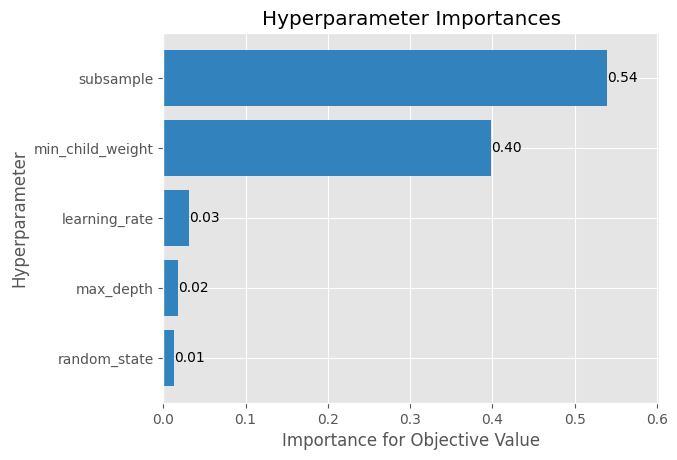

In [36]:
plot_param_importances(find_params)

In [42]:
best_params={'subsample': 0.30000000000000004,
 'learning_rate': 0.003,
 'max_depth': 3,
 'random_state': 36,
 'min_child_weight': 17}

In [43]:
model=xgb.XGBClassifier(**best_params)

In [45]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [46]:
y_pred=model.predict(X_test)

In [47]:
accuracy_score(y_test,y_pred)

0.39705882352941174

## Why Optuna?

- the ability to define Pythonic search spaces using loops and conditionals.
- Platform-agnostic API — you can tune estimators of almost any ML, DL package/framework, including Sklearn, PyTorch, TensorFlow, Keras, XGBoost, LightGBM, CatBoost, etc.
- a large suite of optimization algorithms with early stopping and pruning features baked in.
- it supports optimization of continuous, integer and categorical hyperparameters, as well as hyperparameters with complex dependencies (the optimal value of a hyperparameter may depend on the values of other hyperparameters).
- Easy parallelization with little or no changes to the code.
- Built-in support for visual exploration of search results.

### Differences between Optuna Hyperparamter vs Grid Search vs Random Search 

| Optuna | Grid Search   | Random Search   |
|------|------|------|
|   Based on trail based, follows Bayesian optimization approach  | It gives the results by picking each and every parameter|  It gives the results based on random picking of each parameter     |
|   Takes much time but gives the best optimized hyperparameters  | Takes much time but gives less optimized results compared to Optuna|  It is faster than compared to Grid Search and but may not gurantee for accurate results compared to Optuna    |
|   Has inbuilt methods for data visulization for plotting the results without typing heavy code | Does not have inbuilt plotting | Does not have inbuilt plotting |
|   it can be used for hyperparameters with complex dependencies  | can be used for hyperparameters with complex dependencie but may not be good compared to Optuna | can be used for hyperparameters with complex dependencie but may not be good compared to Optuna |
|   We can also convert to dataframe for finding best hyperparameters in each trail due to its inbuilt features  | It does not have inbuilt features for visualizing the parameters | It does not have inbuilt features for visualizing the parameters |
|   Robust for larger datasets with optimized results | Cannot be used for larger datasets with many hyper parameters | Can be used for larger datasets with many hyper parameters but may not gurantee the optimized results compared to Optuna |